# Академия Аналитиков Авито

# Эконометрика

# Домашняя работа №4

## №1 (40 баллов)

- Вам дан файлик `HW_004_001.csv`
- В нем находится одномерный временной ряд
- Ваша задача подобрать лучшую модель, которая бы описывала эти данные

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import scipy as sp

import statsmodels.formula.api as smf
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf 
from statsmodels.graphics.tsaplots import plot_pacf

import scipy as sp
import seaborn as sns

# Замечательная либа для подключения Yahoo Finance 
import yfinance as yf

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox

from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.ar_model import ar_select_order

import warnings
warnings.filterwarnings('ignore')# Чтобы не раздражали

pd.set_option('display.max_columns', None) # Чтобы показывались все колонки
%matplotlib inline

In [ ]:
def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title, template='plotly_white')
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

In [ ]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
# инициализируем plotly
init_notebook_mode(connected = True)

In [ ]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [ ]:
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

- Начнем с чего простого. Загрузим данные

In [ ]:
df = pd.read_csv('HW_004_001.csv')

In [ ]:
df.head()

date         y
0  2018-07-18  0.101160
1  2018-07-19  0.622773
2  2018-07-20 -0.796028
3  2018-07-21  3.154209
4  2018-07-22  1.800747

- Нарисуем данные

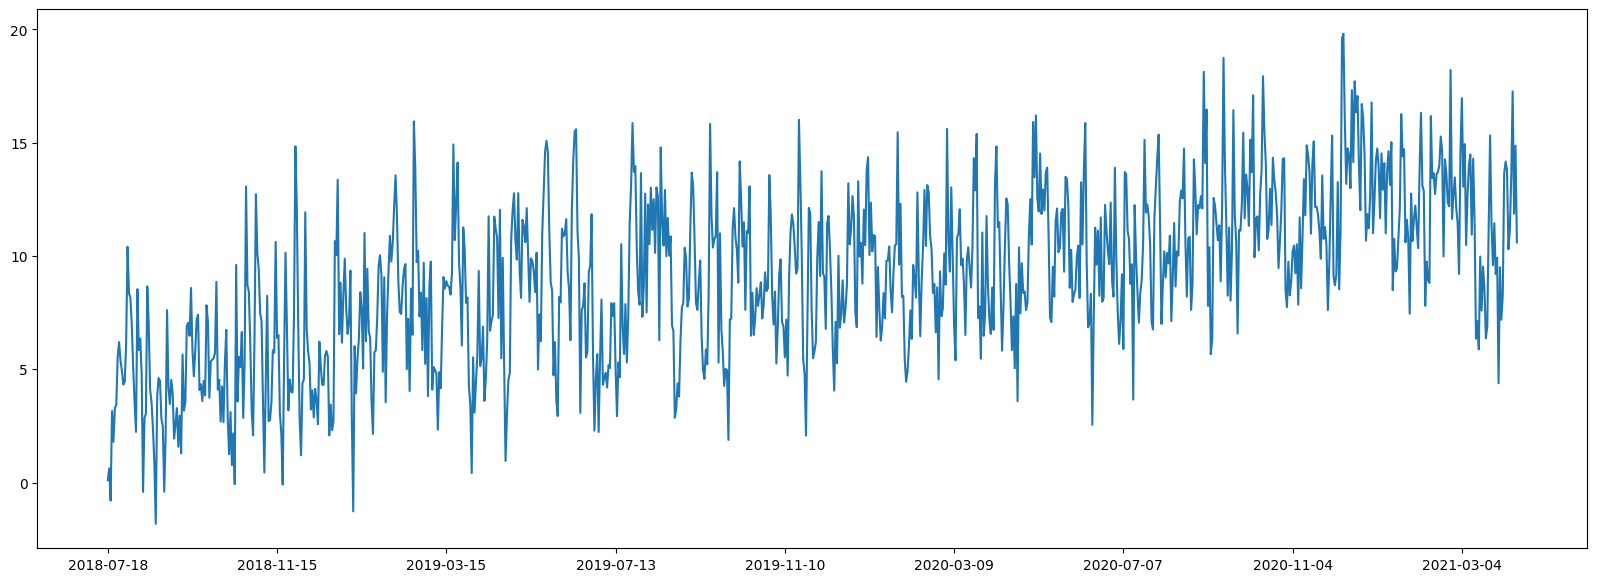

In [ ]:
fig, ax = plt.subplots(figsize=(20, 7))
ax.plot('date', 'y', data=df)
ax.xaxis.set_major_locator(ticker.MultipleLocator(120))

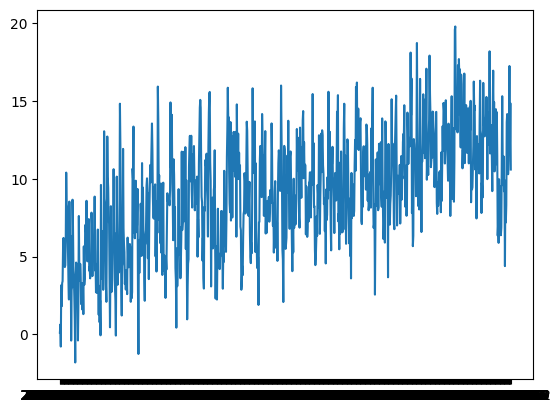

In [ ]:
plt.plot('date', 'y', data=df)

- Можно ли что-то сказать про данные судя по графику?

Есть положительный тренд. 

- Нарисует `ACF()`, `PACF()`

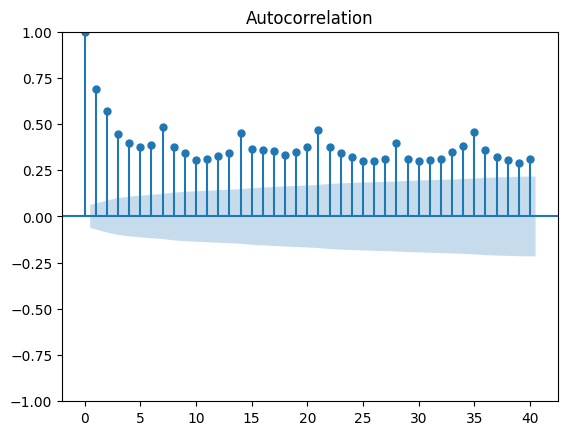

In [ ]:
plot_acf(df['y'], lags = 40)
plt.show()

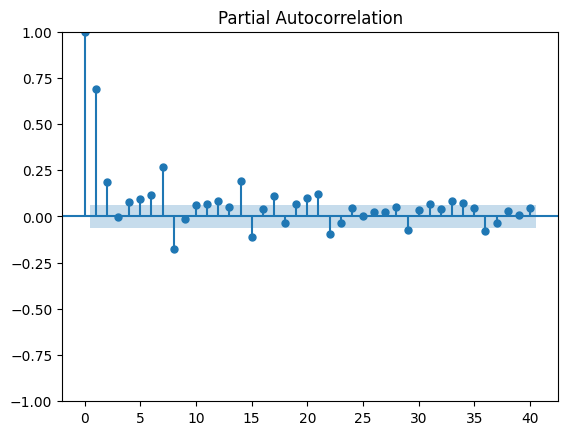

In [ ]:
plot_pacf(df['y'], lags = 40)
plt.show()

С увеличением лагов ACF вроде бы очень слабо, но уменьшается (тренд), есть сезональность. Здесь также можно понять, что ряд нестационарный.

После того, как сразу нарисовали графики, увидели подозрения на нестационарность, есть смысл сначала проверить на стационарность на всякий случай, прийти к стационарному ряду, если он таким не был, а потом только делать выводы по ACF и PACF для моделей.

In [ ]:
adf_test(df['y'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.657991
p-value                          0.081594
#Lags Used                      21.000000
Number of Observations Used    978.000000
Critical Value (1%)             -3.437054
Critical Value (5%)             -2.864500
Critical Value (10%)            -2.568346
dtype: float64


In [ ]:
kpss_test(df['y'])

Results of KPSS Test:
Test Statistic            4.263181
p-value                   0.010000
Lags Used                17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


Получили ожидаемый результат. Теперь приведем ряд к стационарному. Возьмем разницы и посмотрим на тесты для них.

In [ ]:
diff = (df['y'] - df['y'].shift()).dropna()

In [ ]:
adf_test(diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.110450e+01
p-value                        3.792430e-20
#Lags Used                     2.000000e+01
Number of Observations Used    9.780000e+02
Critical Value (1%)           -3.437054e+00
Critical Value (5%)           -2.864500e+00
Critical Value (10%)          -2.568346e+00
dtype: float64


In [ ]:
kpss_test(diff)

Results of KPSS Test:
Test Statistic            0.120416
p-value                   0.100000
Lags Used                96.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


Отлично получили стационарный ряд. Теперь можем построить графики ACF и PACF.

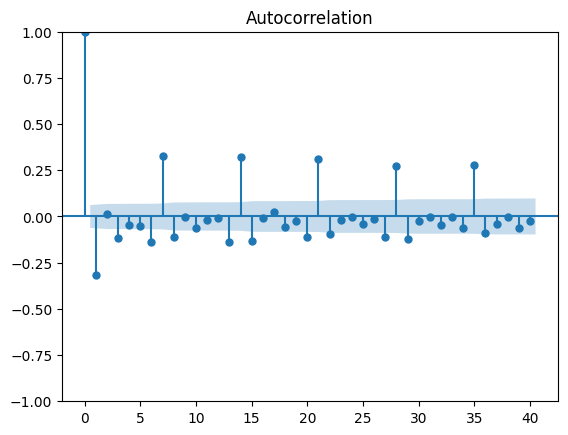

In [ ]:
plot_acf(diff, lags = 40)
plt.show()

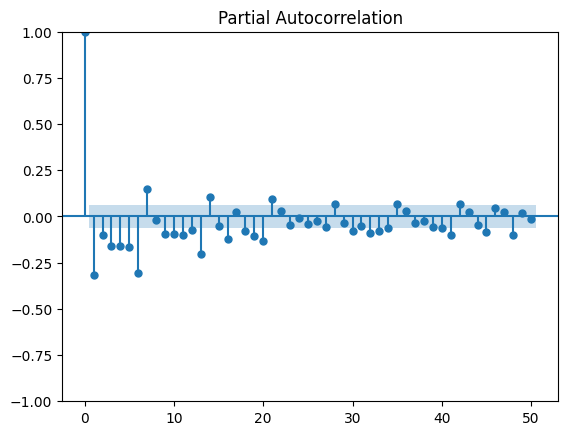

In [ ]:
plot_pacf(diff, lags = 50)
plt.show()

- Можно ли сделать какой-то вывод?

Есть закономерность в лагах кратных 7, поскольку наши данные ежедневные, можно говорить о недельной сезональности.
Если смотреть на график PACF, то 7 значений являются значимыми, а затем начинается синяя область. Предположительно с помощью графиков можно установить ARIMA(7, 1, 1), если использовать старые значения и ARIMA(7, 0, 1), если брать разницы. Далее воспользуемся автоподбором.

- Ну а теперь ваша свобода 
- Продолжите анализ
    - Не забывайте про стационарность
    - А как насчет тренда?
    - Есть ли сезонность?
    - Может быть в [документации](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html) будут еще полезные трюки
    - А может быть будет что-то полезное в [учебнике](https://otexts.com/fpp2/)

С помощью автоподбора подберем спецификацию ARIMA. C pmdarima были проблемы, используют внутри старую версию numpy для float. Поэтому воспользуемся дедовским методом.

In [ ]:
tmp = np.zeros((8, 8))
for p in range(8):
    for q in range(8):
        tmp[p][q] = ARIMA(df.y, order = (p, 1, q)).fit().aic
i,j = np.unravel_index(tmp.argmin(), tmp.shape)
print(i,j)

7 7


In [ ]:
best_arima = ARIMA(df.y, order=(7, 1, 7))
best_arima =  best_arima.fit()
best_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(7, 1, 7)   Log Likelihood               -2222.363
Date:                Fri, 14 Apr 2023   AIC                           4474.726
Time:                        11:17:00   BIC                           4548.327
Sample:                             0   HQIC                          4502.701
                               - 1000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3284      0.035     -9.387      0.000      -0.397      -0.260
ar.L2         -0.3931      0.033    -11.849      0.000      -0.458      -0.328
ar.L3         -0.3449      0.032    -10.635      0.000      -0.408      -0.281
ar.L4         -0.3732      0.035    -10.733      0.000      -0.441      -0.305
ar.L5         -0.3589      0.031    -11.767      0.000      -0.419      -0.299
ar.L6         -0.3455      0.035     -9.748      0.000      -0.415      -0.276
ar.L7          0.5971      0.030     19.600      0.000       0.537       0.657
ma.L1         -0.1353      0.028     -4.747      0.000      -0.191      -0.079
ma.L2          0.1551      0.028      5.459      0.000       0.099       0.211
ma.L3         -0.0683      0.030     -2.315      0.021      -0.126      -0.010
ma.L4          0.0425      0.032      1.336      0.182      -0.020       0.105
ma.L5         -0.0186      0.031     -0.597      0.551      -0.080       0.043
ma.L6         -0.0206      0.029     -0.710      0.478      -0.077       0.036
ma.L7         -0.8317      0.027    -31.285      0.000      -0.884      -0.780
sigma2         5.0515      0.237     21.293      0.000       4.586       5.516
===================================================================================
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):                 0.15
Prob(Q):                              0.47   Prob(JB):                         0.93
Heteroskedasticity (H):               0.87   Skew:                             0.03
Prob(H) (two-sided):                  0.22   Kurtosis:                         3.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

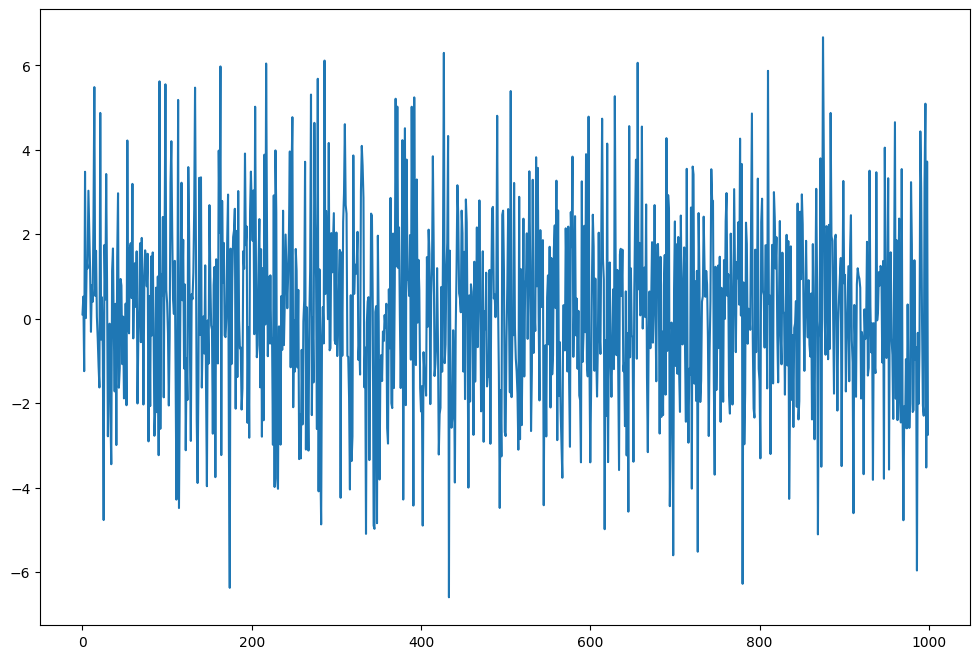

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = best_arima.resid.plot()

Figure(640x480)
Figure(640x480)


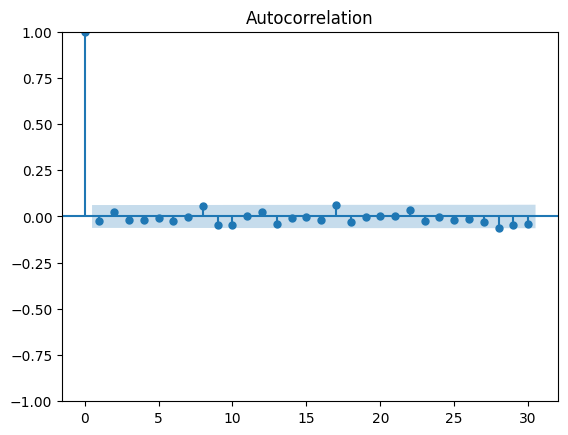

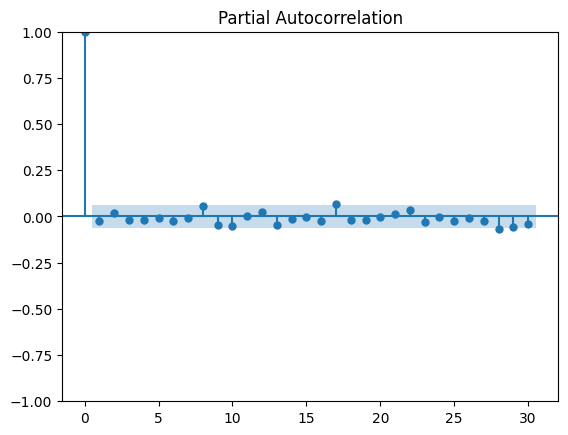

In [ ]:
print(plot_acf(best_arima.resid))
print(plot_pacf(best_arima.resid))

In [ ]:
acorr_ljungbox(best_arima.resid, return_df=True)

lb_stat  lb_pvalue
1    0.494269   0.482029
2    0.968241   0.616239
3    1.423320   0.700078
4    1.815429   0.769658
5    1.920408   0.860045
6    2.507962   0.867576
7    2.537529   0.924245
8    5.881165   0.660541
9    8.025999   0.531528
10  10.193084   0.423720

In [ ]:
acorr_ljungbox(best_arima.resid**2, return_df=True)

lb_stat  lb_pvalue
1   0.234379   0.628296
2   0.624005   0.731980
3   1.371356   0.712263
4   1.434387   0.838197
5   1.809119   0.874876
6   1.949392   0.924294
7   2.721877   0.909484
8   2.821218   0.945071
9   2.825510   0.970813
10  3.748359   0.957986

Кажется, что модель нормальная, но хочется еще посмотреть на SARIMA. Все таки не зря же мы увидели сезонность.

In [ ]:
df['y_diff_7'] = df.y.diff().diff(7).dropna()
df = df.dropna()

In [ ]:
# Посмотрим еще раз на первоначальные данные
plotly_df(df.set_index('date')[['y_diff_7']])

In [ ]:
print(adf_test(df.set_index('date')[['y_diff_7']]),'\n')
print(kpss_test(df.set_index('date')[['y_diff_7']]))

Results of Dickey-Fuller Test:
Test Statistic                -1.358447e+01
p-value                        2.093285e-25
#Lags Used                     2.100000e+01
Number of Observations Used    9.700000e+02
Critical Value (1%)           -3.437109e+00
Critical Value (5%)           -2.864524e+00
Critical Value (10%)          -2.568359e+00
dtype: float64
None 

Results of KPSS Test:
Test Statistic            0.011064
p-value                   0.100000
Lags Used                14.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
None


Отлично получили стационарный ряд. 

Figure(640x480)
Figure(640x480)


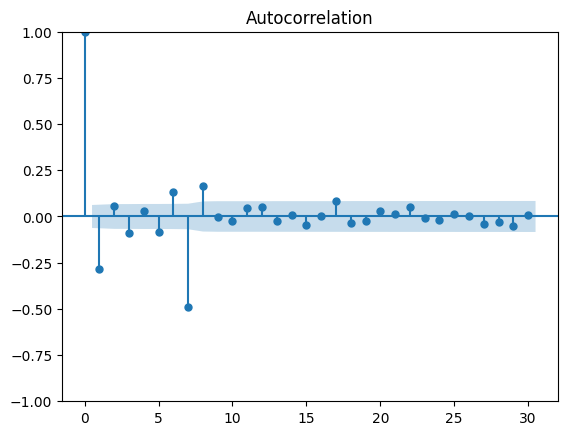

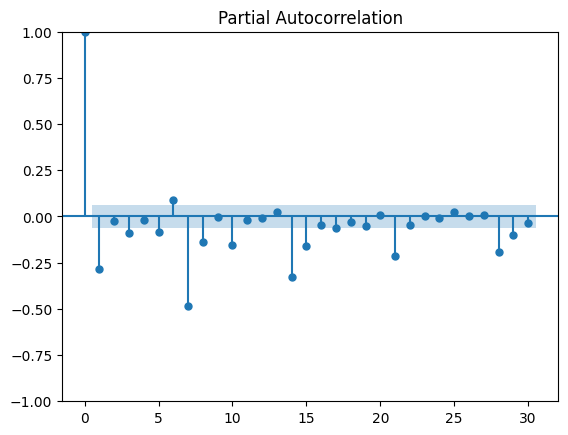

In [ ]:
print(plot_acf(df[['y_diff_7']]))
print(plot_pacf(df.set_index('date')[['y_diff_7']]))

Снова воспользуемся дедовским методом, ограничения ставим +- ориентируясь на графики. 

In [ ]:
# tmp = np.zeros((3, 3, 8, 8))
# for p in range(3):
#     for q in range(3):
#         for P in range(8):
#             for Q in range(8):        
#                 tmp[p][q][P][Q] = ARIMA(df.y, order = (p, 1, q), seasonal_order=(P,1,Q,7)).fit().aic
# i,j,k,l = np.unravel_index(tmp.argmin(), tmp.shape)
# print('One Enternity Later')
# print('')
# print(i,j,k,l)

# Лучший результат - order = (2, 1, 2), seasonal_order=(2,1,3,7)

In [ ]:
best_arima = ARIMA(df.y, order=(2, 1, 2), seasonal_order=(2,1,3,7))
best_arima =  best_arima.fit()
best_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  992
Model:             ARIMA(2, 1, 2)x(2, 1, [1, 2, 3], 7)   Log Likelihood               -2158.512
Date:                                 Fri, 14 Apr 2023   AIC                           4337.024
Time:                                         11:20:54   BIC                           4385.941
Sample:                                              0   HQIC                          4355.631
                                                 - 992                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1024      0.165      0.619      0.536      -0.222       0.427
ar.L2          0.3886      0.094      4.126      0.000       0.204       0.573
ma.L1         -0.5693      0.173     -3.289      0.001      -0.909      -0.230
ma.L2         -0.4276      0.173     -2.473      0.013      -0.766      -0.089
ar.S.L7       -1.2395      0.029    -42.413      0.000      -1.297      -1.182
ar.S.L14      -0.9734      0.028    -34.705      0.000      -1.028      -0.918
ma.S.L7        0.2427      0.960      0.253      0.800      -1.639       2.124
ma.S.L14      -0.2879      1.188     -0.242      0.809      -2.616       2.041
ma.S.L21      -0.9543      0.907     -1.053      0.292      -2.731       0.822
sigma2         4.4928      4.280      1.050      0.294      -3.896      12.881
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 0.87
Prob(Q):                              0.79   Prob(JB):                         0.65
Heteroskedasticity (H):               0.91   Skew:                            -0.02
Prob(H) (two-sided):                  0.37   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Результат получился немного лучше, чем просто ARIMA.   
AIC SARIMA 4337.024  
AIC ARIMA 4474.726  

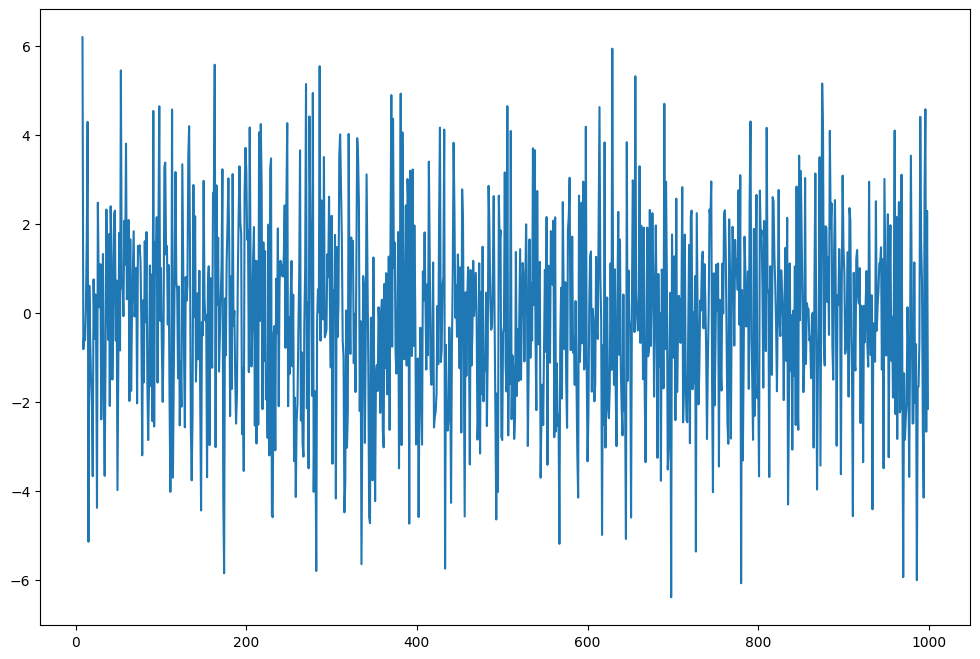

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = best_arima.resid.plot()

Figure(640x480)
Figure(640x480)


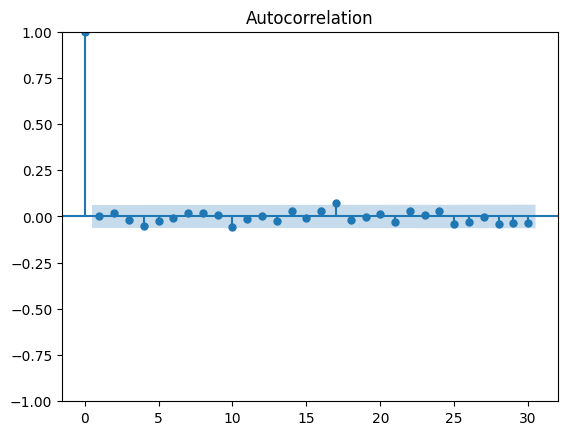

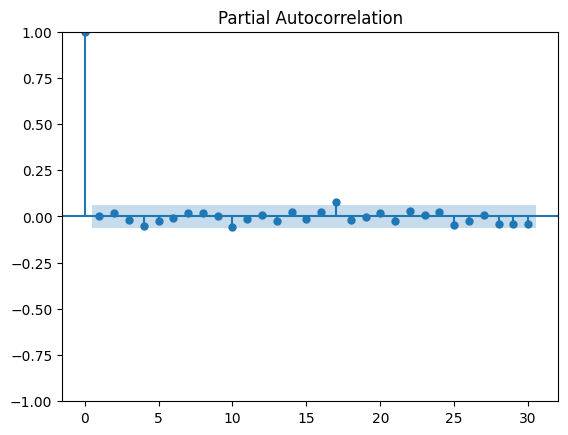

In [ ]:
print(plot_acf(best_arima.resid))
print(plot_pacf(best_arima.resid))

In [ ]:
acorr_ljungbox(best_arima.resid, return_df=True)

lb_stat  lb_pvalue
1   0.017035   0.896157
2   0.383195   0.825639
3   0.773879   0.855704
4   3.237295   0.518928
5   3.814691   0.576392
6   3.917956   0.687778
7   4.246068   0.751039
8   4.676502   0.791526
9   4.705840   0.859160
10  7.822721   0.646148

In [ ]:
acorr_ljungbox(best_arima.resid**2, return_df=True)

lb_stat  lb_pvalue
1    0.017373   0.895138
2    1.890470   0.388588
3    2.023101   0.567626
4    6.340489   0.175122
5    6.502173   0.260373
6    7.611917   0.267936
7    7.848536   0.346139
8    7.858226   0.447440
9    8.220236   0.512113
10  10.573428   0.391702

В целом можно выбирать любую из двух моделей.

**Далее будет две задачи. Вам надо выбрать одну. Если вы сделаете и 2.1, и 2.2, то будет выбран минимальный балл из двух**

## №2.1 (60 баллов)

- Не буду расписывать задание (как самый настоящий менеджер)
- На занятии вы разбирали данные о продажах Walmart для прогнозирования ежедневных продаж на следующие 28 дней. С кейсом можно озанкомиться на kaggle: [M5 Forecasting - Uncertainty](https://www.kaggle.com/c/m5-forecasting-uncertainty/overview). Продолжим с ними работать.
- Вам необходимо сделать модель предсказания продаж в штате Висконсин (WI) категории Hobbies в целом (не углубляясь до торговых точек)
- Данные берем [отсюда](https://www.kaggle.com/c/m5-forecasting-uncertainty/data)

In [ ]:
# Помните, что вам нужно выбрать нужные данные (штат Висконсин и категория Хобби)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import scipy as sp

import statsmodels.formula.api as smf
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf 
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

import scipy as sp
import seaborn as sns

# Модельки
from statsmodels.tsa.arima.model import ARIMA
# Тесты
from statsmodels.tsa.stattools import adfuller, kpss, acf

import prophet as fp 
import datetime
import time

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go

from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import add_changepoints_to_plot


import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

# инициализируем plotly
init_notebook_mode(connected = True)

pd.set_option('display.max_columns', None) # Чтобы показывались все колонки
%matplotlib inline

In [ ]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput, '\n Null Hypothesis: The series has a unit root.')
    
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output, '\n Null Hypothesis: The process is trend stationary.')

In [ ]:
# опишем функцию, которая будет визуализировать все колонки dataframe в виде line plot
def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title, template='plotly_white')
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)
    
# Функция для получения данных 'mdape', 'mape', 'mtape' для модели по методу имитированных исторических прогнозов
def perf_metrics_28d(fp_model):
    fp_df_cv = cross_validation(fp_model, initial='730.25 days', period='28 days', horizon = '28 days', parallel="processes")
    res = performance_metrics(fp_df_cv,rolling_window = 1)
    return res

**Получение данных**

In [ ]:
# Получение и обработка исходных данных.

# Тренировочный датафрейм с проданными айтемами
sales_train_evaluation = pd.read_csv('sales_train_evaluation.csv')

# Будем работать не с каждой конкретной точкой, а с продажами в каждом конкретном штате по категориям
stv_cols = [c for c in sales_train_evaluation.columns if c not in ['id','item_id','dept_id','store_id']]
sales_train_evaluation = sales_train_evaluation[stv_cols].groupby(['cat_id','state_id'], as_index = False).sum()

# Преобразуем данные в удобный формат
stv_cols_tr = [c for c in stv_cols if c not in ['cat_id','state_id']]
sales_train_evaluation = pd.melt(sales_train_evaluation, id_vars = ['cat_id','state_id'], \
                                value_vars = stv_cols_tr)

In [ ]:
# Cправочник дат. SNAP - индикатор участия магазина в программе льготной покупки продуктов (Supplemental Nutrition Assistance Program)
calendar = pd.read_csv('calendar.csv', parse_dates = ['date'])
calendar['date'] = calendar.date.dt.date
calendar = calendar[['date', 'd', 'event_name_1','event_type_1','event_name_2','event_type_2', \
                     'snap_CA', 'snap_TX', 'snap_WI']]

In [ ]:
# Присоединение дат к id
sales_train_evaluation.columns = ['cat_id', 'state_id', 'd', 'y']
sales_train_evaluation = sales_train_evaluation.merge(calendar[['d', 'date']], how = 'left', on = 'd')

In [ ]:
# Приведение к нужному для fbprophet виду
sales_train_evaluation = sales_train_evaluation[['date', 'state_id', 'cat_id', 'y']]
sales_train_evaluation.columns = ['ds', 'state_id', 'cat_id', 'y']

In [ ]:
# Выделим только данные по Висконсину
wi_data = sales_train_evaluation.loc[sales_train_evaluation.state_id == 'WI', ['ds', 'cat_id', 'y']].copy()

In [ ]:
# Для нашего примера поработаем только с категорией 'HOBBIES'

data = wi_data.loc[(wi_data.cat_id == 'HOBBIES')&(wi_data.ds<=datetime.date(2016,4,24)),['ds', 'y']].copy().reset_index(drop = True)

data_evaluation = wi_data.loc[(wi_data.cat_id == 'HOBBIES'),['ds', 'y']].copy().reset_index(drop = True)


In [ ]:
import holidays

us_wi_holidays = holidays.UnitedStates(state='WI', years = [2011,2012,2013,2014,2015,2016,2017,2018], \
                                       observed = False)

holiday_df = pd.DataFrame.from_dict(us_wi_holidays, orient='index').reset_index(drop = False)
holiday_df.columns = ['ds', 'holiday']
holiday_df = holiday_df.sort_values('ds').reset_index(drop = True)
holiday_df['lower_window'] = -1
holiday_df['upper_window'] = 1
holiday_df = holiday_df[['holiday', 'ds', 'lower_window', 'upper_window']]

# В данных calendar в качестве событий были отмечены Пасха и День отца
# Эти два регулярных события тоже могут отражаться на покупках (следует проверить данный факт отдельно)
# Но сейчас в рамках нашей задачи мы так же вынесем эти дни + Valentine's Day в датафрейм с праздниками
# В эти дни продажи отличаются от аналогичных обычных дней

custom_holidays = pd.DataFrame([{'holiday' : "Father's day", 'ds' : datetime.date(2011,6,19), \
                                 'lower_window':-2, 'upper_window':0},
 {'holiday' : "Father's day", 'ds' : datetime.date(2012,6,17), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Father's day", 'ds' : datetime.date(2013,6,16), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Father's day", 'ds' : datetime.date(2014,6,15), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Father's day", 'ds' : datetime.date(2015,6,21), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Father's day", 'ds' : datetime.date(2016,6,19), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Father's day", 'ds' : datetime.date(2017,6,18), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Father's day", 'ds' : datetime.date(2018,6,17), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2011,4,24), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2012,4,15), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2013,5,5), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2014,4,20), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2015,4,12), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2016,5,1), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2017,4,16), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2018,4,8), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2011,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2012,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2013,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2014,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2015,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2016,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2017,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2018,2,14), 'lower_window':-1, 'upper_window':1}])

holiday_df = pd.concat([holiday_df, custom_holidays])
holiday_df = holiday_df.sort_values('ds').reset_index(drop = True)
holiday_df.head()

holiday          ds  lower_window  upper_window
0              New Year's Day  2011-01-01            -1             1
1  Martin Luther King Jr. Day  2011-01-17            -1             1
2             Valentine's Day  2011-02-14            -1             1
3        Susan B. Anthony Day  2011-02-15            -1             1
4       Washington's Birthday  2011-02-21            -1             1

In [ ]:
data.head()

ds     y
0  2011-01-29  1083
1  2011-01-30   926
2  2011-01-31   684
3  2011-02-01   455
4  2011-02-02   132

In [1]:
# Нарисуйте


<ipython-input-148-17b659fe4825>:1: RuntimeWarning:

Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.



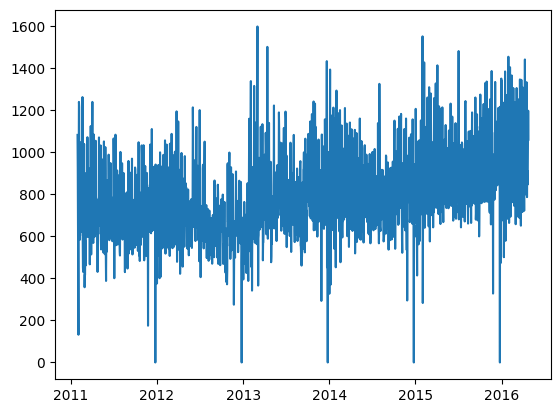

In [ ]:
plt.plot('ds', 'y', data=data)

- Что можете сказать?  


Почему-то plotly не построился, пришлось построить по простому. Видим два тренда до середины 2012 он отрицательный, затем положительный тренд, после 2014 есть некая годовая сезональность.

In [ ]:
# Попробуйте зафиттить базовую модель


In [ ]:
# Базовая модель
m = fp.Prophet()
m.fit(data)
future = m.make_future_dataframe(periods=28)
forecast = m.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


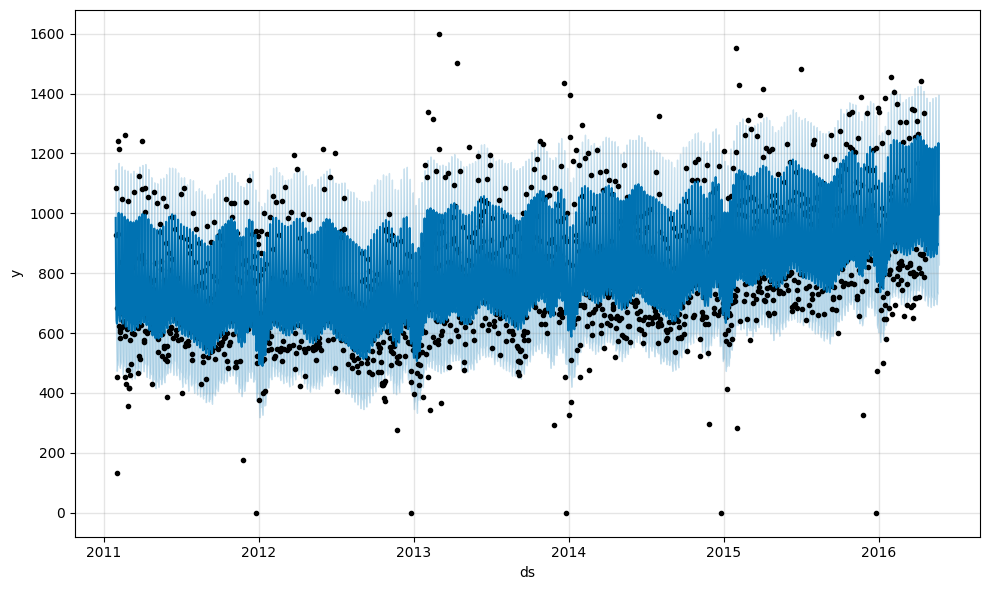

In [ ]:
fig1 = m.plot(forecast)

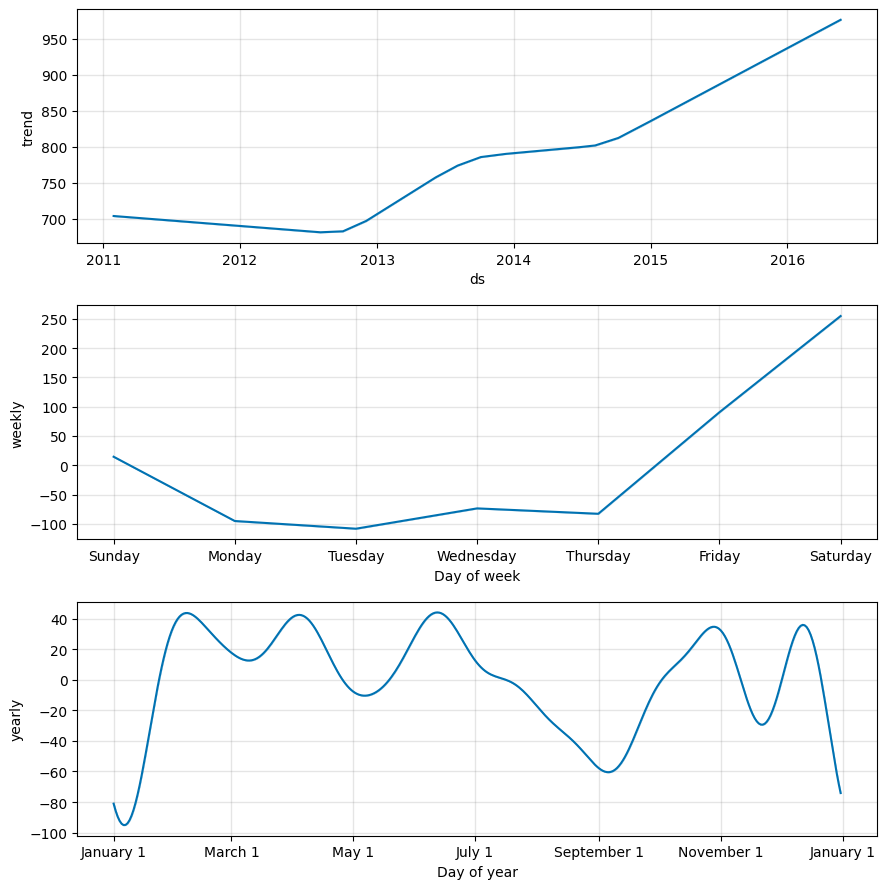

In [ ]:
fig2 = m.plot_components(forecast)

- Что у вас получилось? 
- Что еще можете сказать, скажем, по поводу компонентов модели?


Модель получилась так себе. Мы правильно увидели тренд. В выходные дни люди тратят деньги на хобби (прибавляем значение), что не удивительно. В начале месяца спады, начало года финаносовго спады.

- На занятии вам показывали 100500 параметров, с которыми можно поиграться, чтобы получить "лучшую" модель
- Во-первых, начнем с последнего, какзалось бы, шага. Какую метрику вы будете использовать? Почему?
- Каким именно способом вы будете проводить диагностику модели и сравнивать модели?
- Какие параметры вы будете менять? Почему? Попробуйте предположить, как именно необходимо поменять параметр модели, прежде чем приступать к тестированию. За неверное предположение баллы сниматься не будут при наличии обоснования.
- Как еще можно улучшить модель? Что можно добавить еще?

Будем использовать метрику MAPE и ее модификации, поскольку по смыслу задачи нет ограничений ее использовать, она широко используется и легко интерпретируется. Для диагностики будем смотреть на метрики и визуально на график предсказания, также будет пользоваться кросс-валидацией.

In [ ]:
# посчитаем MAPE базовая модель
data_evaluation['ds'] = pd.to_datetime(data_evaluation['ds'])
data['ds'] = pd.to_datetime(data['ds'])
data_w_error = data_evaluation.merge(forecast[['ds','yhat']], on = ['ds'], how='left')
data_w_error['mape'] = abs(data_w_error['y'] - data_w_error['yhat'])/data_w_error['y']
print('MAPE is: ', np.mean(data_w_error[data_w_error['ds']>max(data['ds'])]['mape']))

MAPE is:  0.08282873584488173


In [ ]:
df_cv = cross_validation(m, initial='730.5 days', period='28 days', horizon = '28 days', parallel="processes")
res = performance_metrics(df_cv,rolling_window = 1)
res

INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f49381e92e0>
INFO:prophet:Skipping MAPE because y close to 0


horizon           mse        rmse         mae     mdape     smape  coverage
0 28 days  19888.585867  141.026898  102.563197  0.097804  0.127618  0.814626

<ipython-input-154-c4eb53485993>:1: RuntimeWarning:

Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.



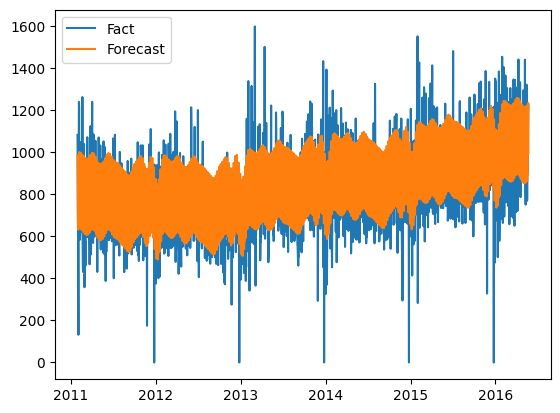

In [ ]:
plt.plot('ds', 'y', data=data_w_error, label='Fact')
plt.plot('ds', 'yhat', data=data_w_error, label='Forecast')
plt.legend()
plt.show()

В основном не добивает, а в переломе трендов наооборот. Поиграемся с параметрами.

1. Точки изменения тренда. Параметры n_changepoints, changepoint_prior_scale, changepoint_range следует попробовать покрутить, т.к. нужно почетче уловить тренд и его изломы, выше мы увидели, что наша модель делает это не очень хорошо.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4932b7b040>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


  horizon           mse        rmse         mae     mdape     smape  coverage
0 28 days  19888.585867  141.026898  102.563197  0.097804  0.127618  0.814626


INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4933a312b0>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


  horizon           mse        rmse        mae     mdape     smape  coverage
0 28 days  19885.286206  141.015198  102.61825  0.098367  0.127675  0.816327


INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4931912b50>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


  horizon           mse        rmse        mae     mdape     smape  coverage
0 28 days  19862.817338  140.935508  102.46891  0.097956  0.127501  0.814626


INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4933a7c520>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


  horizon           mse        rmse         mae     mdape     smape  coverage
0 28 days  19886.347474  141.018961  102.534976  0.097652  0.127563  0.813776


INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f493e9db310>
INFO:prophet:Skipping MAPE because y close to 0


  horizon           mse        rmse        mae     mdape    smape  coverage
0 28 days  19877.339028  140.987017  102.51426  0.097748  0.12757  0.812925


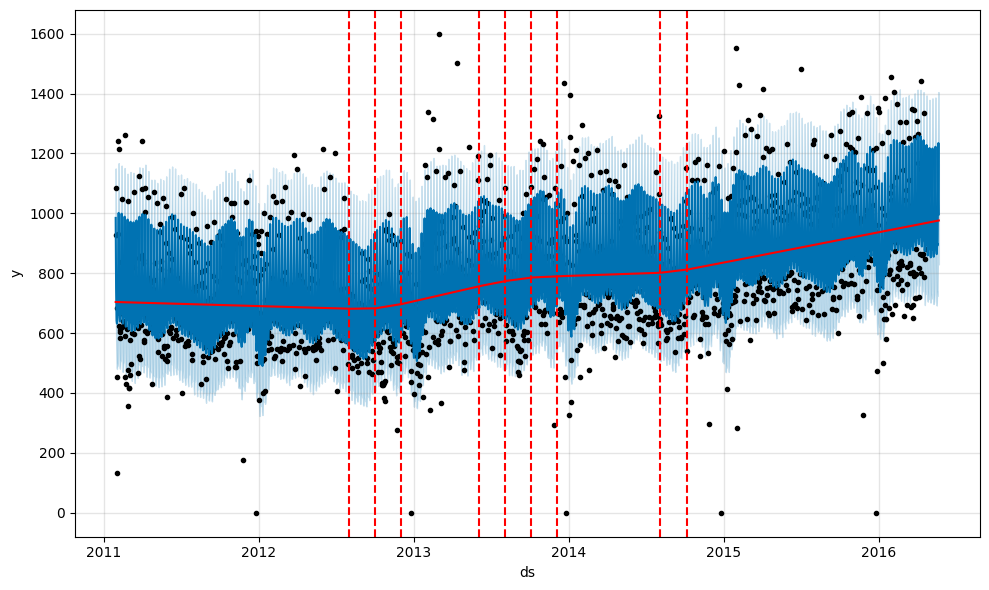

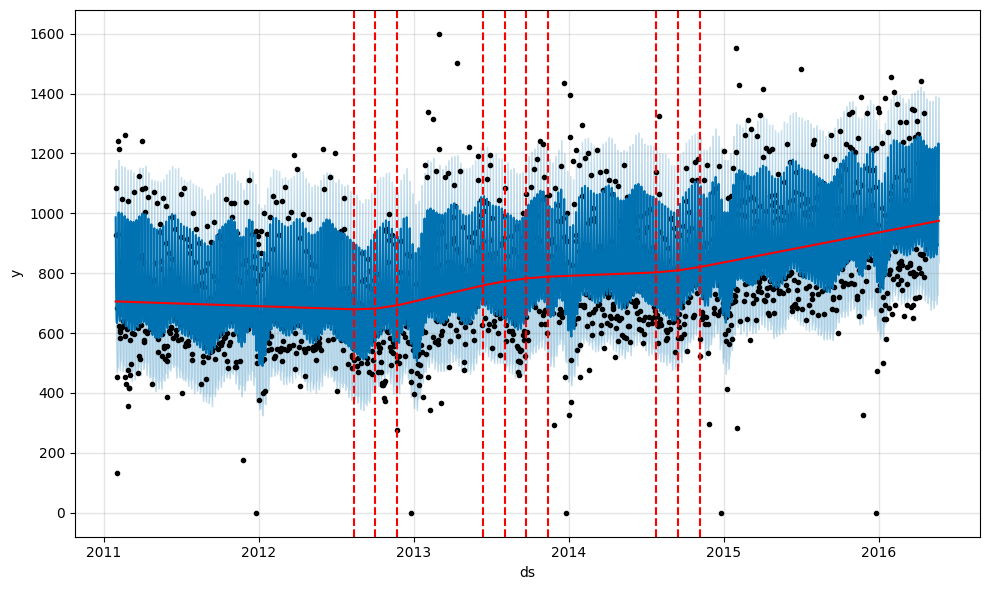

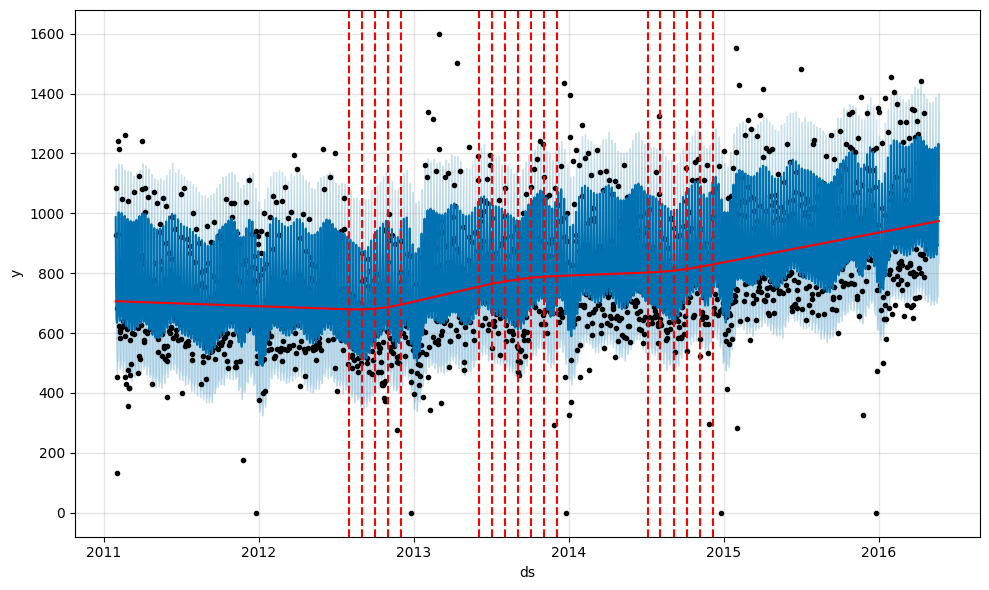

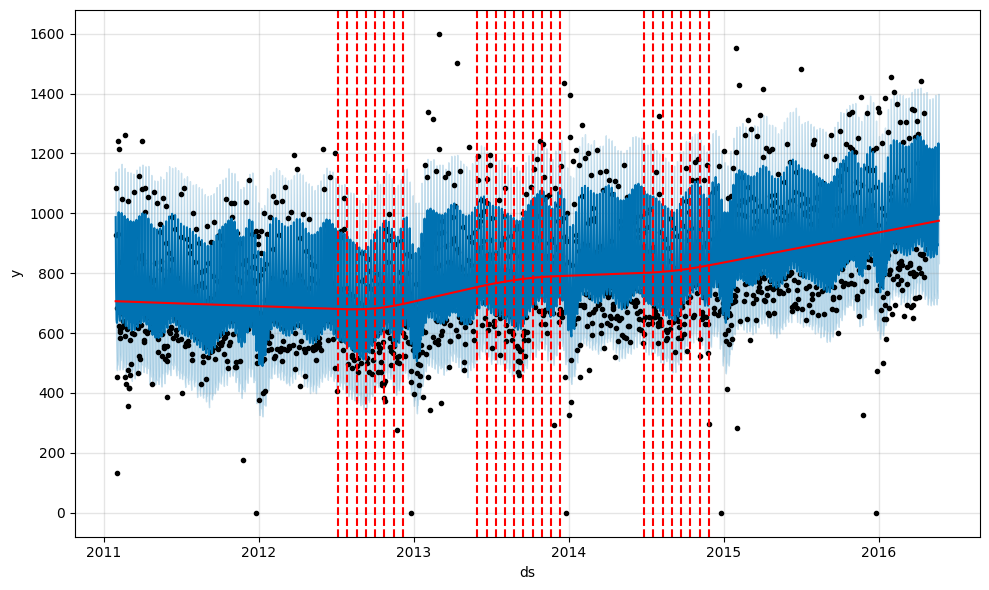

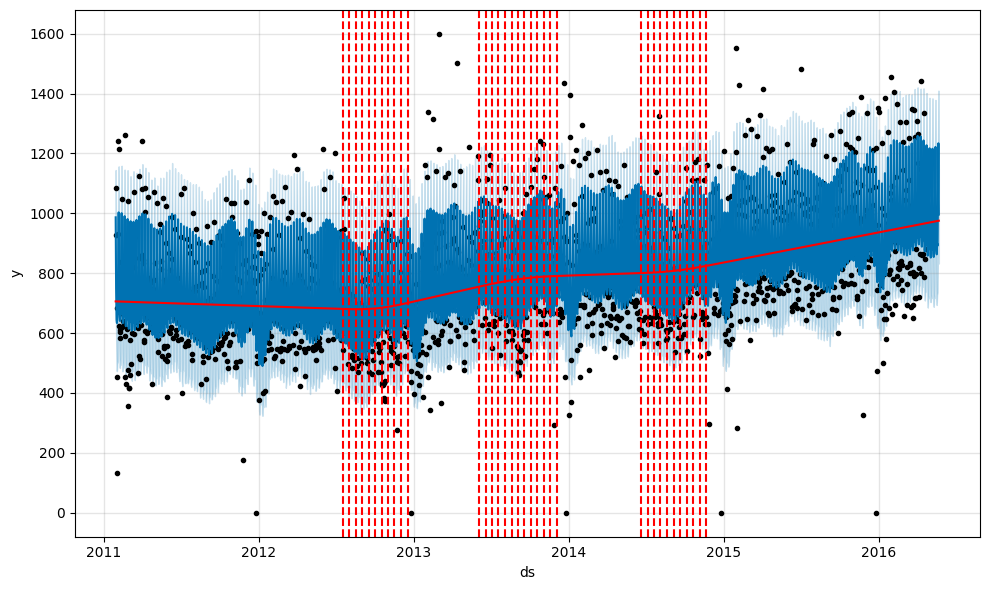

In [ ]:
for ncp in [25, 30, 50, 70, 100]:

    m_1 = fp.Prophet(
        n_changepoints=ncp
        )
    m_1.fit(data)

    future = m_1.make_future_dataframe(periods=28)
    forecast = m_1.predict(future)
    fig3 = m_1.plot(forecast)

    a = add_changepoints_to_plot(fig3.gca(), m_1, forecast)
    m1_metrics = perf_metrics_28d(m_1)
    print(m1_metrics)

По метрикам сильных улучшений не увидели, но в целом 50-70 точек получше, много брать не стоит тоже, чтобы не переобучиться. Посмотрим на другие параметры.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4932b39fd0>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


  horizon           mse        rmse         mae     mdape    smape  coverage
0 28 days  21242.551984  145.748249  106.950396  0.098755  0.13375   0.80017


INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4933a10d30>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


  horizon           mse        rmse         mae     mdape     smape  coverage
0 28 days  19888.585867  141.026898  102.563197  0.097804  0.127618  0.812075


INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4932101220>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


  horizon          mse        rmse         mae     mdape     smape  coverage
0 28 days  19714.71127  140.409085  101.745102  0.093515  0.126751  0.809524


INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f493376d130>
INFO:prophet:Skipping MAPE because y close to 0


  horizon           mse        rmse        mae     mdape     smape  coverage
0 28 days  19494.769085  139.623669  100.34304  0.093096  0.124802  0.814626


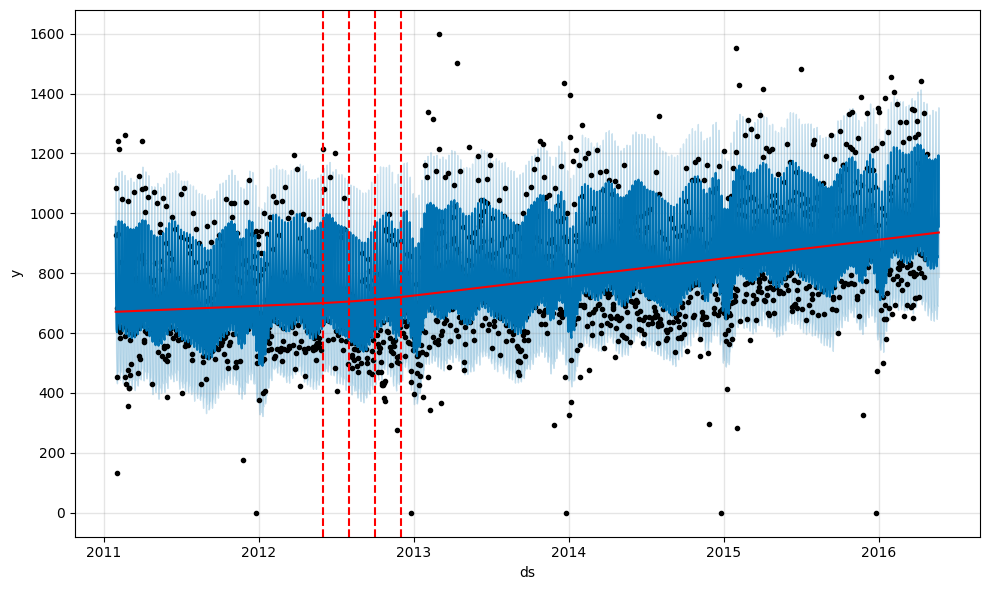

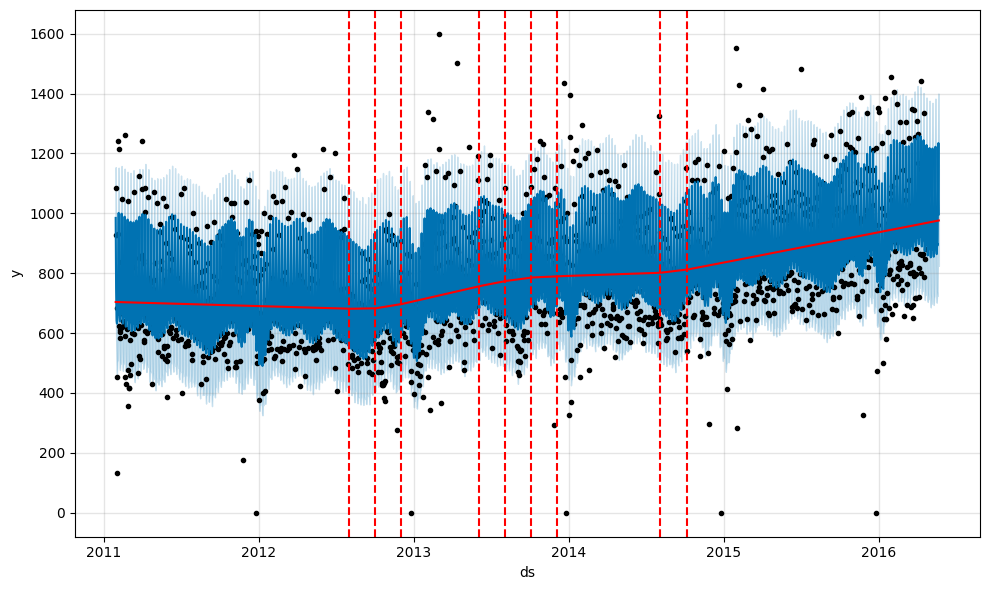

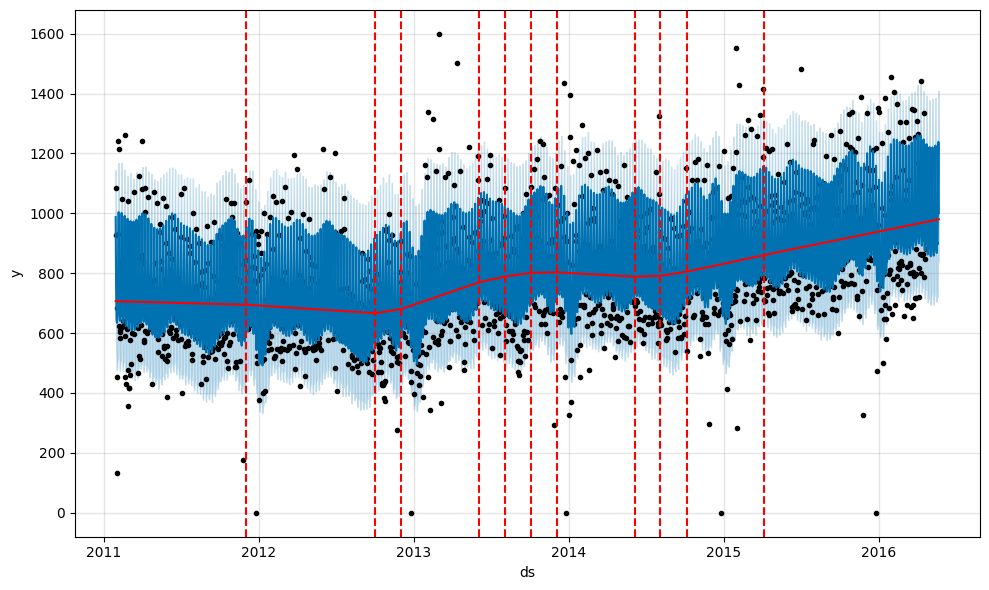

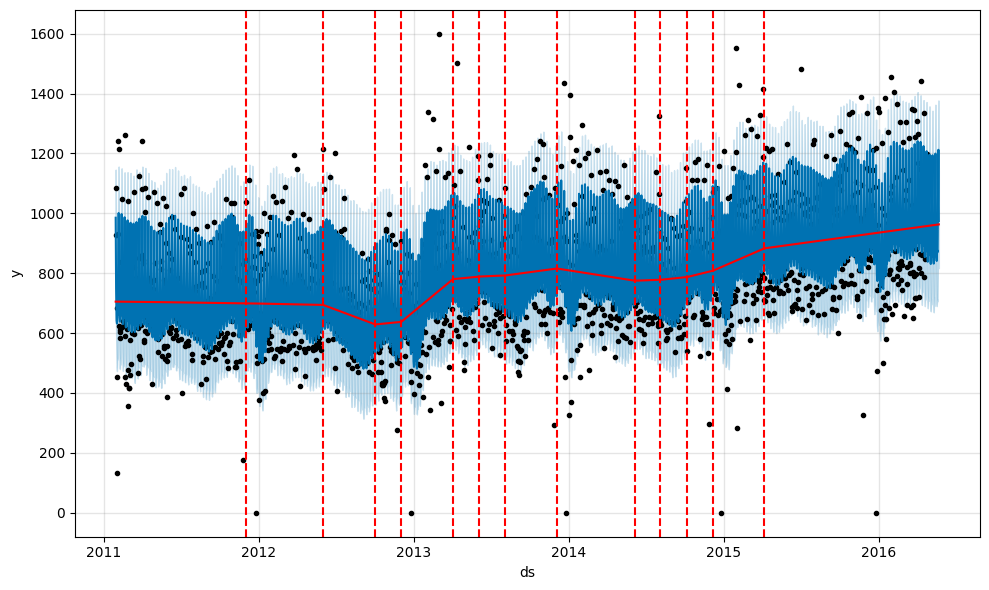

In [ ]:
for cps in [0.005, 0.05, 0.1, 0.5]:

    m_1 = fp.Prophet(
        changepoint_prior_scale=cps
        )
    m_1.fit(data)

    future = m_1.make_future_dataframe(periods=28)
    forecast = m_1.predict(future)
    fig3 = m_1.plot(forecast)

    a = add_changepoints_to_plot(fig3.gca(), m_1, forecast)
    m1_metrics = perf_metrics_28d(m_1)
    print(m1_metrics)

На глаз 0.1 показал хороший результат, не слишком переобучен, не слишком недоучен.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4932b1a2b0>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


  horizon           mse        rmse         mae     mdape     smape  coverage
0 28 days  20772.823742  144.127803  106.071525  0.099358  0.132101  0.791667


INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4932ab9f10>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


  horizon           mse        rmse         mae     mdape     smape  coverage
0 28 days  19888.585867  141.026898  102.563197  0.097804  0.127618  0.809524


INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4932a0bc40>
INFO:prophet:Skipping MAPE because y close to 0


  horizon           mse        rmse         mae     mdape     smape  coverage
0 28 days  19826.911057  140.808065  102.216937  0.097478  0.127232  0.812925


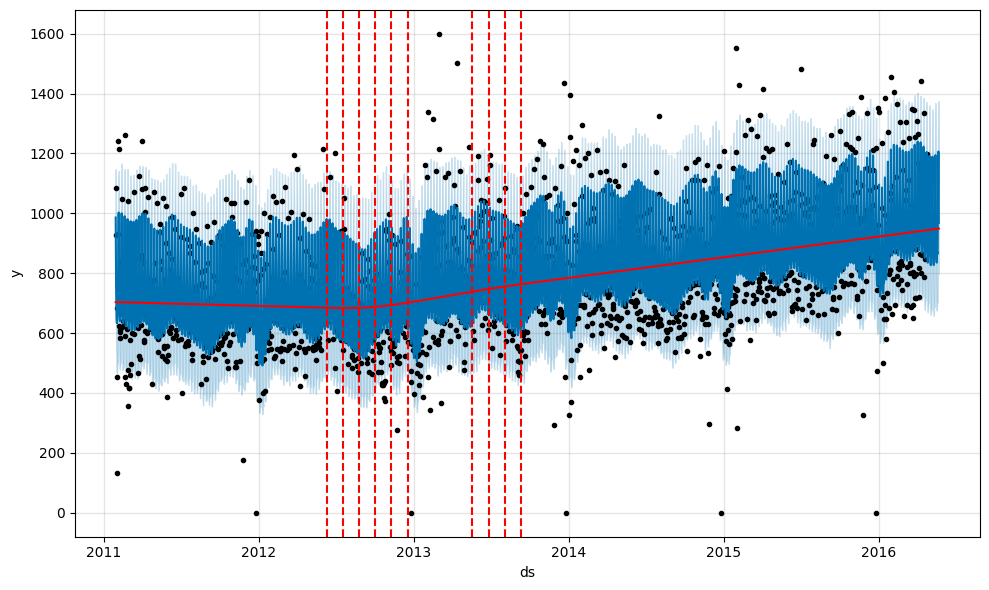

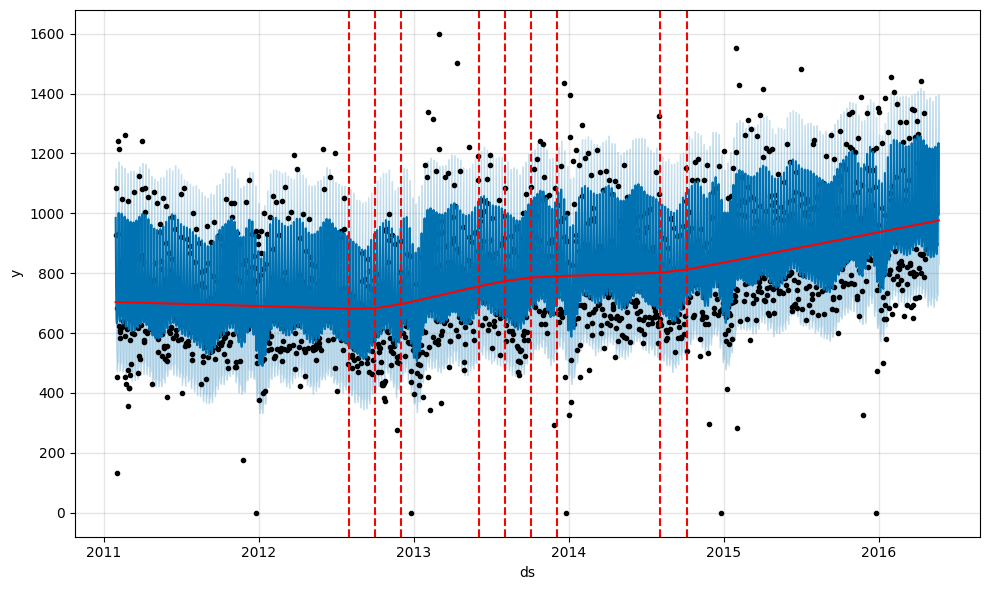

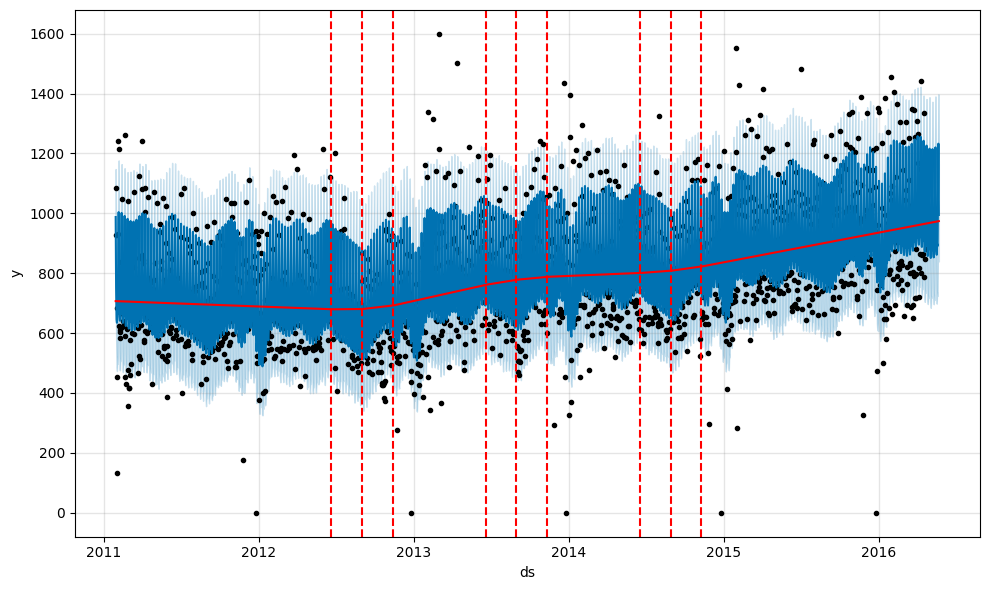

In [ ]:
for cr in [0.5, 0.8, 0.95]:

    m_1 = fp.Prophet(
        changepoint_range=cr
        )
    m_1.fit(data)

    future = m_1.make_future_dataframe(periods=28)
    forecast = m_1.predict(future)
    fig3 = m_1.plot(forecast)

    a = add_changepoints_to_plot(fig3.gca(), m_1, forecast)
    m1_metrics = perf_metrics_28d(m_1)
    print(m1_metrics)

Можно оставить дефолное значение.

Посмотрим, что будет если мы объединим наши результаты


In [ ]:
m_1 = fp.Prophet(
    n_changepoints=50,
    changepoint_prior_scale = 0.1

)
m_1.fit(data)
future = m_1.make_future_dataframe(periods=28)
forecast = m_1.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


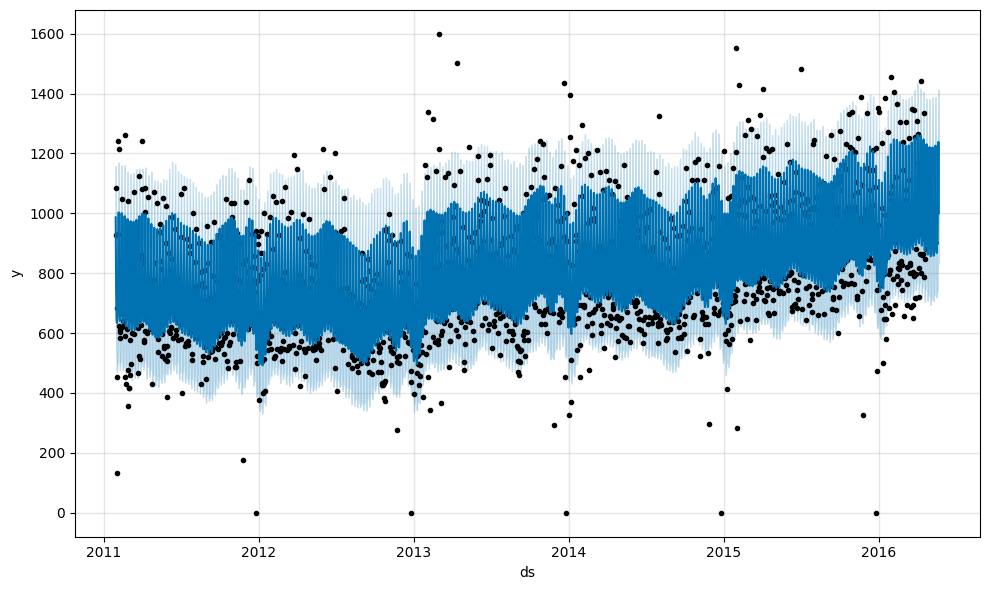

In [ ]:
fig4 = m_1.plot(forecast)

In [ ]:
data_evaluation['ds'] = pd.to_datetime(data_evaluation['ds'])
data['ds'] = pd.to_datetime(data['ds'])
data_w_error = data_evaluation.merge(forecast[['ds','yhat']], on = ['ds'], how='left')
data_w_error['mape'] = abs(data_w_error['y'] - data_w_error['yhat'])/data_w_error['y']
print('MAPE is: ', np.mean(data_w_error[data_w_error['ds']>max(data['ds'])]['mape']))

MAPE is:  0.08198484489605926


In [ ]:
df_cv = cross_validation(m_1, initial='730.5 days', period='28 days', horizon = '28 days', parallel="processes")
res = performance_metrics(df_cv,rolling_window = 1)
res

INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4932a2d7c0>
INFO:prophet:Skipping MAPE because y close to 0


horizon           mse       rmse         mae     mdape     smape  coverage
0 28 days  19699.135973  140.35361  101.732773  0.093244  0.126751  0.818027

Стало лучше, но не сильно. Идем дальше.

2. Сезонные компоненты. На графике до этого мы видели что-то похожее на сезонность, поэтому нам нужно поработать со следующими параметрами - seasonality_mode, seasonality_prior_scale. Кажется, что нам нужна будет аддитивная сезональность, поскольку сезонные колебания хобби должны быть +- постоянны.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


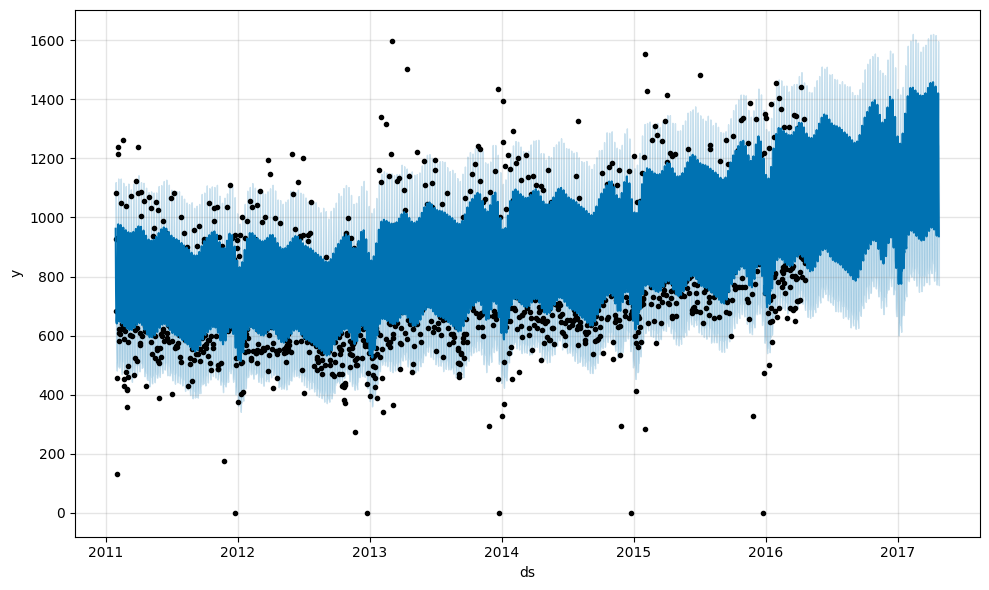

In [ ]:
# мультипликативная

m_2 = fp.Prophet(
    seasonality_mode = 'multiplicative')

m_2.fit(data)

future = m_2.make_future_dataframe(periods=365)

forecast = m_2.predict(future)
fig5 = m_2.plot(forecast)

In [ ]:
m2_metrics = perf_metrics_28d(m_2)
m2_metrics

INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4932040880>
INFO:prophet:Skipping MAPE because y close to 0


horizon           mse        rmse         mae     mdape     smape  coverage
0 28 days  20034.122921  141.541948  103.320619  0.096092  0.128361  0.803571

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


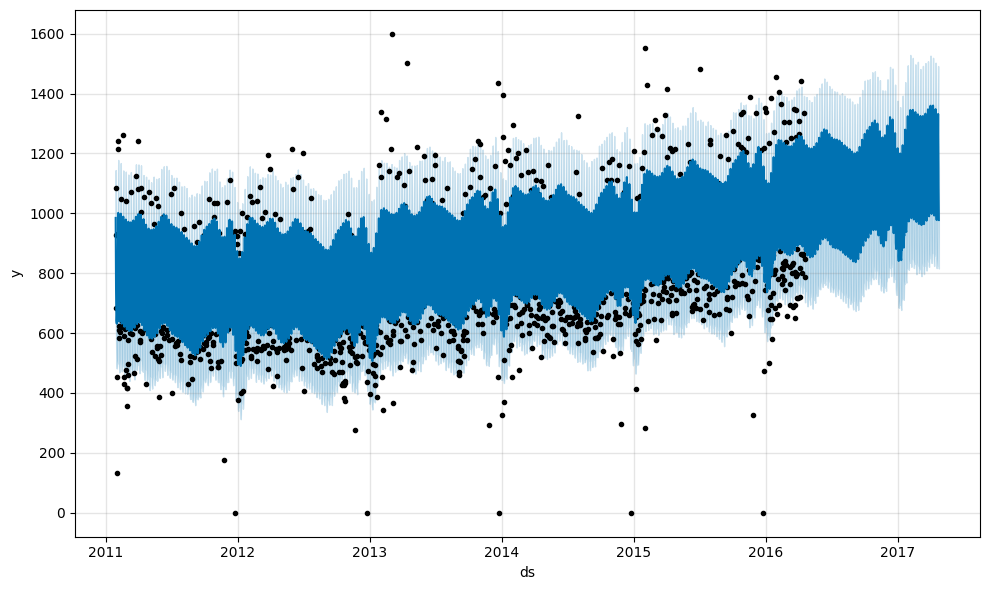

In [ ]:
# аддитивная

m_2 = fp.Prophet(
    seasonality_mode = 'additive')

m_2.fit(data)

future = m_2.make_future_dataframe(periods=365)

forecast = m_2.predict(future)
fig5 = m_2.plot(forecast)

In [ ]:
m2_metrics = perf_metrics_28d(m_2)
m2_metrics

INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4932ed7640>
INFO:prophet:Skipping MAPE because y close to 0


horizon           mse        rmse         mae     mdape     smape  coverage
0 28 days  19888.585867  141.026898  102.563197  0.097804  0.127618  0.806122

Вообще результаты не сильно отличаются, в том числе и от базовой. Попробуем более тонкую настройку для обоих вариантов.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


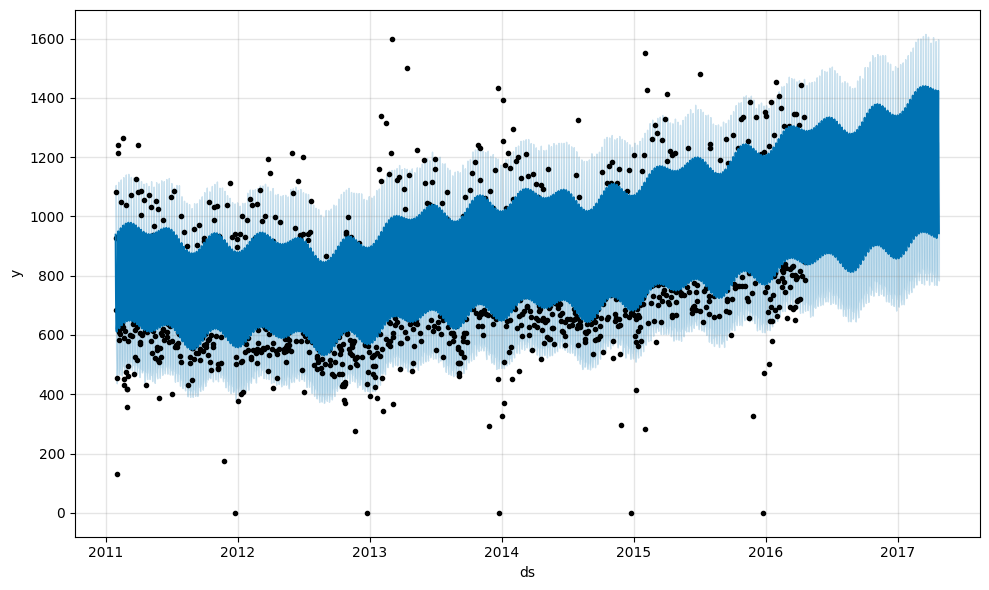

In [ ]:
m_3_mult = fp.Prophet(
    seasonality_mode = 'multiplicative',
    yearly_seasonality = False)

m_3_mult.add_seasonality(name = 'yearly', 
                       period = 365.25,
                       fourier_order = 3, 
                       mode = 'additive')


m_3_mult.fit(data)

future = m_3_mult.make_future_dataframe(periods=365)

forecast = m_3_mult.predict(future)
fig7 = m_3_mult.plot(forecast)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


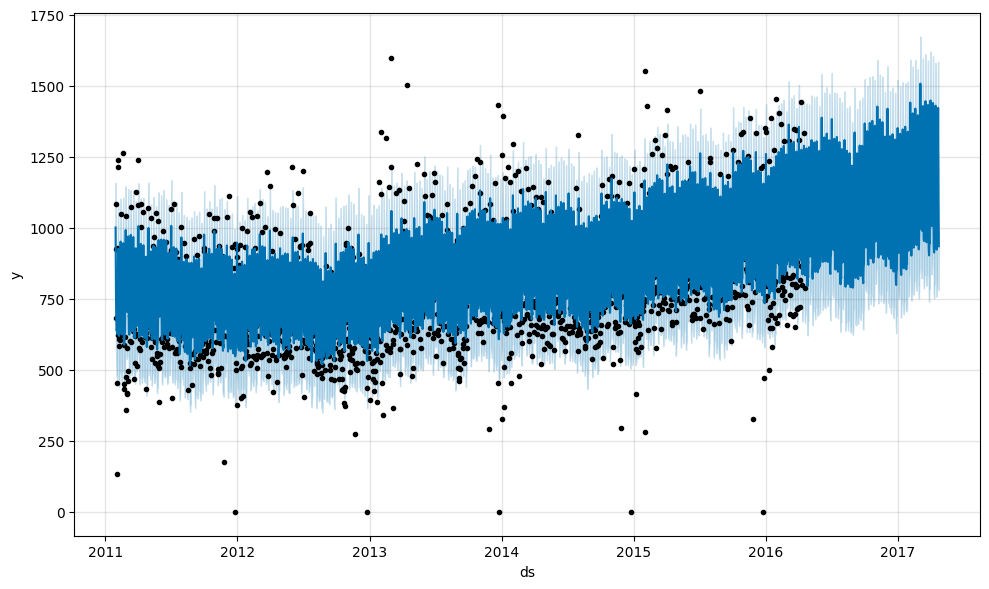

In [ ]:
m_4 = fp.Prophet(
    seasonality_mode = 'multiplicative',
    yearly_seasonality = False)

m_4.add_seasonality(name = 'yearly', 
                       period = 365.25,
                       fourier_order = 3, 
                       mode = 'multiplicative')

m_4.add_seasonality(name = 'monthly', 
                       period = 30.5,
                       fourier_order = 3, 
                       mode = 'additive')


m_4.fit(data)

future = m_4.make_future_dataframe(periods=365)

forecast = m_4.predict(future)
fig7 = m_4.plot(forecast)

In [ ]:
m4_metrics = perf_metrics_28d(m_4)
m4_metrics

INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f49328a1190>
INFO:prophet:Skipping MAPE because y close to 0


horizon           mse        rmse         mae     mdape     smape  coverage
0 28 days  18852.457771  137.304253  100.985539  0.091569  0.125653  0.817177

Добавим к предыдущей настройке.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


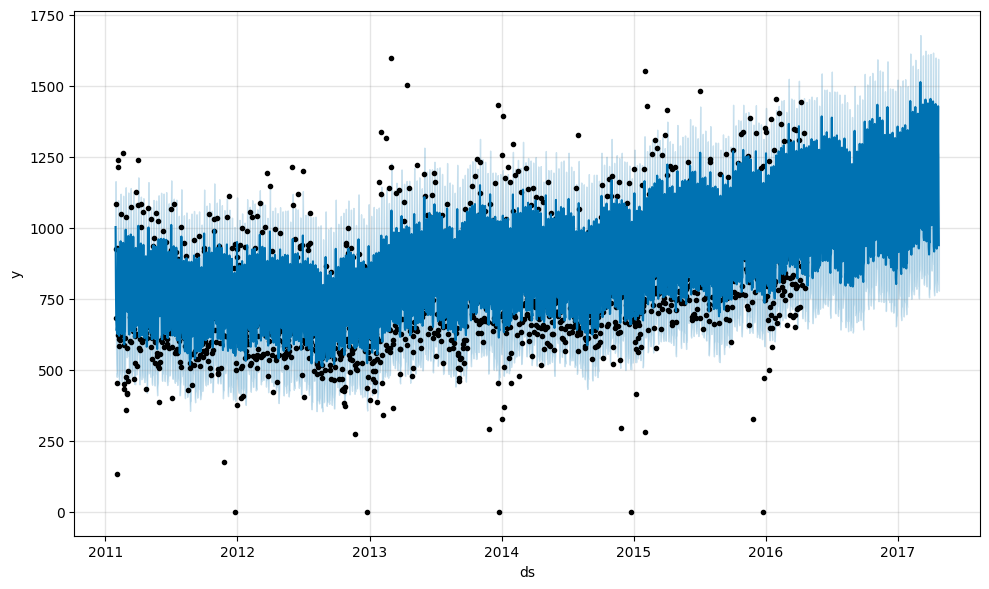

In [ ]:
m_5 = fp.Prophet(
    n_changepoints=50,
    changepoint_prior_scale = 0.1,
    seasonality_mode = 'multiplicative',
    yearly_seasonality = False)

m_5.add_seasonality(name = 'yearly', 
                       period = 365.25,
                       fourier_order = 3, 
                       mode = 'multiplicative')

m_5.add_seasonality(name = 'monthly', 
                       period = 30.5,
                       fourier_order = 3, 
                       mode = 'additive')


m_5.fit(data)

future = m_5.make_future_dataframe(periods=365)

forecast = m_5.predict(future)
fig8 = m_5.plot(forecast)

In [ ]:
m5_metrics = perf_metrics_28d(m_5)
m5_metrics

INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4933904ee0>
INFO:prophet:Skipping MAPE because y close to 0


horizon          mse        rmse         mae     mdape     smape  coverage
0 28 days  18803.41758  137.125554  100.178675  0.088538  0.124736  0.810374

3. Попробуем добавить праздники, т.к. в праздники люди могут больше тратиться на хобби.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


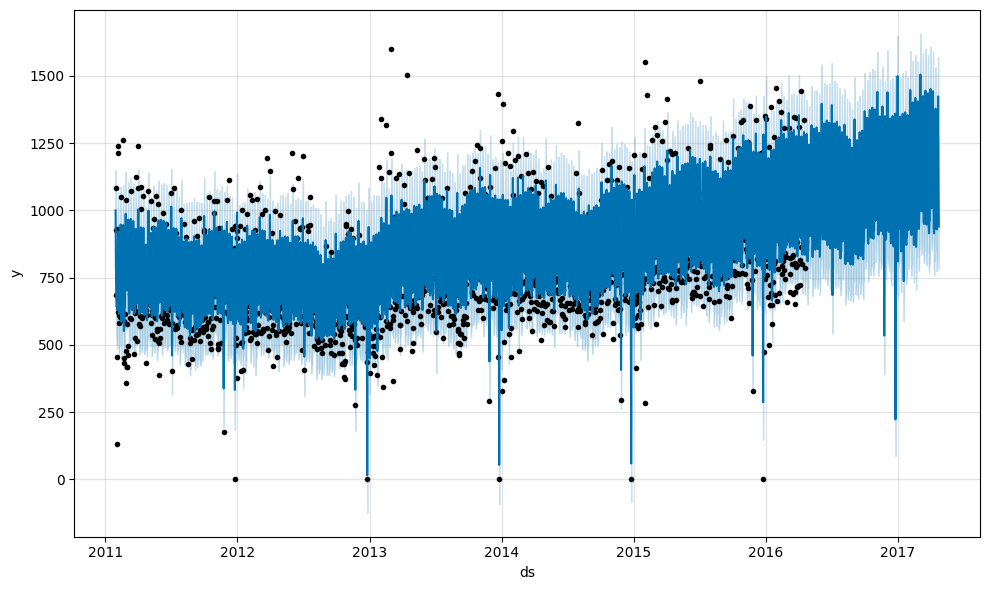

In [ ]:
m_6 = fp.Prophet(
    n_changepoints=50,
    changepoint_prior_scale = 0.1,
    holidays = holiday_df,
    holidays_prior_scale=0.1,
    seasonality_mode = 'multiplicative',
    yearly_seasonality = False)

m_6.add_seasonality(name = 'yearly', 
                       period = 365.25,
                       fourier_order = 3, 
                       mode = 'multiplicative')

m_6.add_seasonality(name = 'monthly', 
                       period = 30.5,
                       fourier_order = 3, 
                       mode = 'additive')


m_6.fit(data)

future = m_6.make_future_dataframe(periods=365)

forecast = m_6.predict(future)
fig9 = m_6.plot(forecast)

In [ ]:
m6_metrics = perf_metrics_28d(m_6)
m6_metrics

INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f49386478e0>
INFO:prophet:Skipping MAPE because y close to 0


horizon         mse       rmse        mae     mdape     smape  coverage
0 28 days  16583.8429  128.77827  97.628026  0.089148  0.123151  0.788265

Праздники довольно не плохо повлияли.

- А что если попробовать воспользоваться моделями другого класса? Давайте воспользуемся моделями класса [SARIMAX](https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_sarimax_stata.html). Это обобщение класса SARIMA. Исопльзование внешних регрессоров не обязательно.
- Является временной ряд, с которым вы работаете стационарным? Тренд стационарым? Стационарным в разностях?
- Сколько лагов стоит использовать?

In [ ]:
data

ds     y
0    2011-01-29  1083
1    2011-01-30   926
2    2011-01-31   684
3    2011-02-01   455
4    2011-02-02   132
...         ...   ...
1908 2016-04-20   846
1909 2016-04-21   881
1910 2016-04-22  1014
1911 2016-04-23  1198
1912 2016-04-24  1060

[1913 rows x 2 columns]

Figure(640x480)
Figure(640x480)


/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



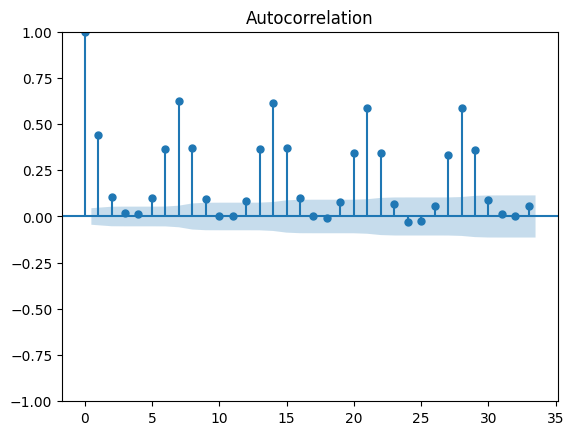

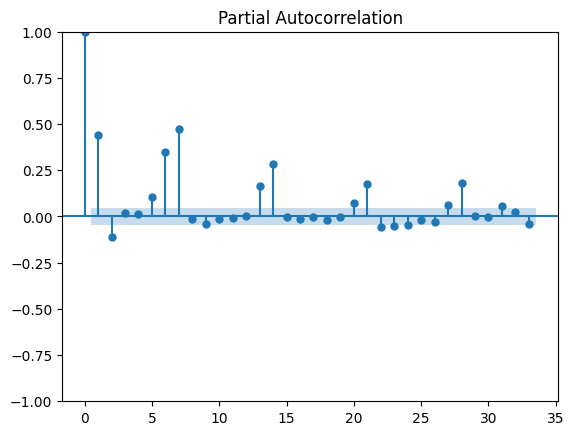

In [ ]:
print(plot_acf(data.y))
print(plot_pacf(data.y))

In [ ]:
adf_test(data.y)

Results of Dickey-Fuller Test:
Test Statistic                   -3.021206
p-value                           0.032961
#Lags Used                       26.000000
Number of Observations Used    1886.000000
Critical Value (1%)              -3.433822
Critical Value (5%)              -2.863074
Critical Value (10%)             -2.567586
dtype: float64 
 Null Hypothesis: The series has a unit root.


In [ ]:
kpss_test(data.y)

Results of KPSS Test:
Test Statistic            8.153917
p-value                   0.010000
Lags Used                14.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64 
 Null Hypothesis: The process is trend stationary.


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




Ряд не стационарный.

Визуально возьмем 7 лагов.

In [ ]:
data['y_diff_7'] = data.y.diff().diff(7).dropna()
data = data.dropna()

Figure(640x480)
Figure(640x480)


/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



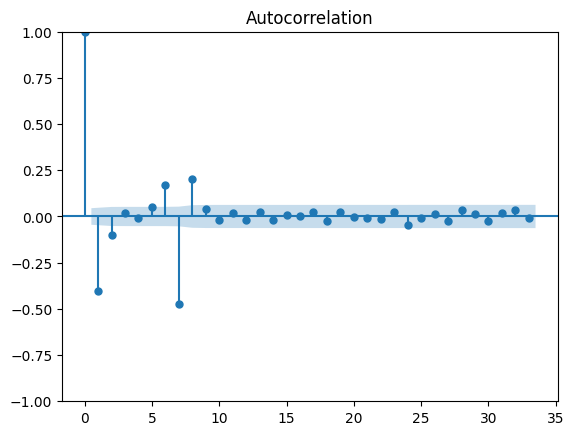

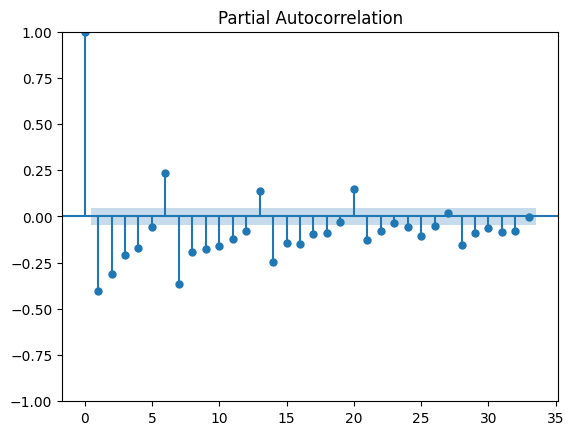

In [ ]:
print(plot_acf(data[['y_diff_7']]))
print(plot_pacf(data.set_index('ds')[['y_diff_7']]))

In [ ]:
print(adf_test(data.set_index('ds')[['y_diff_7']]),'\n')
print(kpss_test(data.set_index('ds')[['y_diff_7']]))

Results of Dickey-Fuller Test:
Test Statistic                -1.470264e+01
p-value                        2.930267e-27
#Lags Used                     2.600000e+01
Number of Observations Used    1.878000e+03
Critical Value (1%)           -3.433837e+00
Critical Value (5%)           -2.863080e+00
Critical Value (10%)          -2.567590e+00
dtype: float64 
 Null Hypothesis: The series has a unit root.
None 

Results of KPSS Test:
Test Statistic            0.013948
p-value                   0.100000
Lags Used                41.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64 
 Null Hypothesis: The process is trend stationary.
None


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




Ряд стал стационарным.

In [ ]:
import pmdarima as pm

In [ ]:
# автоподбор
model2 = pm.auto_arima(data.y, #time series
                      d=1, # difference order
                      D=1, # seasonal difference order
                      max_p = 2,
                      max_q = 2,                       
                      information_criterion='aic', # used to select best mode
                      m=7, # number of periods in each season
                      max_P = 7,
                      start_Q = 0,
                      max_Q=7,
                      seasonal=True, # enable sasonal component
                      trace=True, # prints the information_criterion for each model it fits
                      error_action='ignore', # ignore orders that don't work
                      stepwise=True, # apply an intelligent order search
                      suppress_warnings=True) 

# Print model summary
print(model2.summary())

# # result = ARIMA(2,1,0)(7,1,0)[7]

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,0)[7]             : AIC=inf, Time=7.01 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=25799.141, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=24952.233, Time=0.81 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=1.86 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=25460.468, Time=0.13 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=24743.859, Time=2.21 sec
 ARIMA(1,1,0)(3,1,0)[7]             : AIC=24610.489, Time=4.00 sec
 ARIMA(1,1,0)(4,1,0)[7]             : AIC=24569.306, Time=5.62 sec
 ARIMA(1,1,0)(5,1,0)[7]             : AIC=24514.187, Time=7.83 sec
 ARIMA(1,1,0)(6,1,0)[7]             : AIC=24486.760, Time=15.12 sec
 ARIMA(1,1,0)(7,1,0)[7]             : AIC=24465.220, Time=17.40 sec
 ARIMA(1,1,0)(7,1,1)[7]             : AIC=inf, Time=66.81 sec
 ARIMA(1,1,0)(6,1,1)[7]             : AIC=inf, Time=52.04 sec
 ARIMA(0,1,0)(7,1,0)[7]             : AIC=24827.540, Time=5.95 sec
 ARIMA(2,1,0)(7,1,0)[7]             : A

In [ ]:
best_arima = ARIMA(data.y, order=(2, 1, 0), seasonal_order=(7,1,0,7))
best_arima =  best_arima.fit()
best_arima.summary()

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:                               y   No. Observations:                 1905
Model:             ARIMA(2, 1, 0)x(7, 1, 0, 7)   Log Likelihood              -12127.749
Date:                         Fri, 14 Apr 2023   AIC                          24275.498
Time:                                 15:16:13   BIC                          24330.978
Sample:                                      0   HQIC                         24295.923
                                        - 1905                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5481      0.015    -35.857      0.000      -0.578      -0.518
ar.L2         -0.3114      0.018    -17.230      0.000      -0.347      -0.276
ar.S.L7       -0.8290      0.021    -38.586      0.000      -0.871      -0.787
ar.S.L14      -0.6909      0.027    -25.824      0.000      -0.743      -0.638
ar.S.L21      -0.5542      0.030    -18.357      0.000      -0.613      -0.495
ar.S.L28      -0.4109      0.031    -13.307      0.000      -0.471      -0.350
ar.S.L35      -0.3637      0.031    -11.666      0.000      -0.425      -0.303
ar.S.L42      -0.2313      0.029     -7.928      0.000      -0.289      -0.174
ar.S.L49      -0.1092      0.023     -4.809      0.000      -0.154      -0.065
sigma2      2.083e+04    392.303     53.091      0.000    2.01e+04    2.16e+04
===================================================================================
Ljung-Box (L1) (Q):                   8.42   Jarque-Bera (JB):              2499.38
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.32   Skew:                            -0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
forecast_sarima = best_arima.predict()
forecast_sarima


forecast_test_sarima = best_arima.forecast(28)

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



- А теперь давайте сравним предсказания моделей двух классов.
- Каким тестом воспользуетесь?
- Какие у данного теста есть ограничения?
- Какую модель в итоге будете использовать?

Diebold-Mariano test.Ограничения: модели линейные и не вложенные. У нас вроде бы все подходит.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


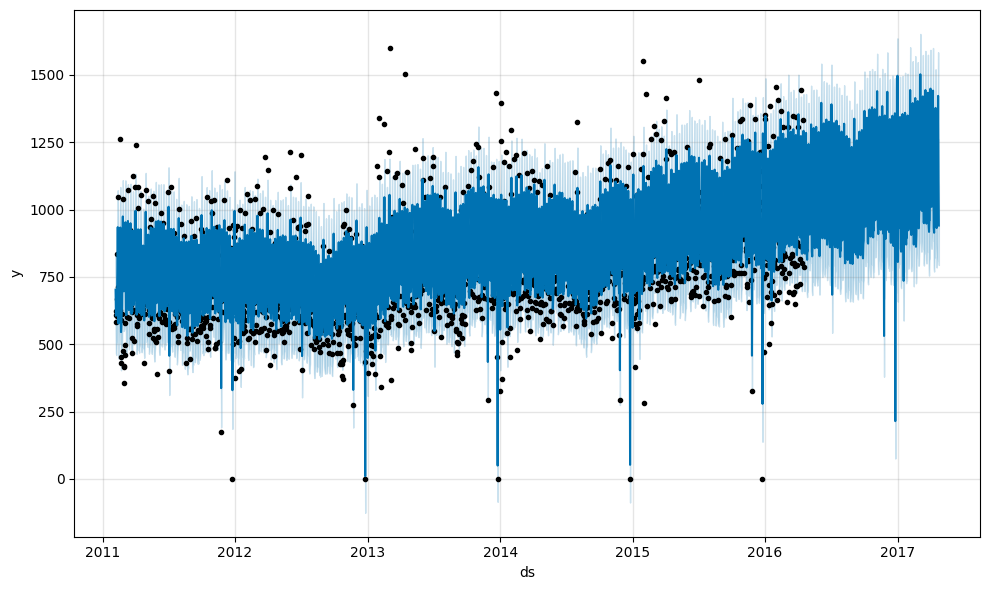

In [ ]:
m_6 = fp.Prophet(
    n_changepoints=50,
    changepoint_prior_scale = 0.1,
    holidays = holiday_df,
    holidays_prior_scale=0.1,
    seasonality_mode = 'multiplicative',
    yearly_seasonality = False)

m_6.add_seasonality(name = 'yearly', 
                       period = 365.25,
                       fourier_order = 3, 
                       mode = 'multiplicative')

m_6.add_seasonality(name = 'monthly', 
                       period = 30.5,
                       fourier_order = 3, 
                       mode = 'additive')


m_6.fit(data)

future = m_6.make_future_dataframe(periods=365)

forecast_season_fp = m_6.predict(future)
fig9 = m_6.plot(forecast_season_fp)

In [ ]:
forecast_season_fp['ds']

0      2011-02-06
1      2011-02-07
2      2011-02-08
3      2011-02-09
4      2011-02-10
          ...    
2265   2017-04-20
2266   2017-04-21
2267   2017-04-22
2268   2017-04-23
2269   2017-04-24
Name: ds, Length: 2270, dtype: datetime64[ns]

In [ ]:
forecast_season_fp['ds'] = pd.to_datetime(forecast_season_fp['ds'])
data_w_error = data.merge(forecast_season_fp, how='left', on='ds')[['ds','y','yhat']]
resid_prophet = (data_w_error.y-data_w_error.yhat).dropna()

resid_sarima = best_arima.resid

dt = np.array(resid_prophet**2)-np.array(resid_sarima**2)

In [ ]:
from scipy import stats
stats.ttest_1samp(dt, popmean=0, alternative='less')

TtestResult(statistic=-7.512820605583045, pvalue=4.424306050086445e-14, df=1904)

По тесту отклоняем нулевую гипотезу, а значит Prophet лучше

**Опционально**
- Можете посмотреть также на [Model Confidence Set](http://www.econ.upf.edu/~lugosi/hansen.pdf) (в [R](https://deliverypdf.ssrn.com/delivery.php?ID=721006122086126029008122096102104025121057026076017028009004070073075030011117018067003018063048018122018101098004022095096104106042011054015086010014019009066093071037037090073072109011022065022092067068097122090073100031093118107026068100105029083&EXT=pdf&INDEX=TRUE)) 
- Какое-то подобие на [Python](https://michael-gong.com/blogs/model-confidence-set/)

## №2.2 (60 баллов)

- Вы молодой, энергичный трейдер

![image.png](attachment:image.png)

- Вы хотите применить свои знания моделей временных рядов для предсказания движения цен акций
- Для этого вы используете библиотеку `yfinance` (советую устанавливать с помощью `pip`, а не `conda install`), чтобы скачать котировки акций
- Вы должны выбрать одну акцию, которая есть в этом источнике и которая вам нравится
- После этого вы должны сделать все то же, самое, что делали в прошлом пункте - выбрать лучше модель, которая описывает данные
- Надеюсь, вы помните, что я говорил про цены и доходности, на занятии
- Однако вас волнует больше всего предсказательная способность модели, а не то, насколько хорошо она описывает данные
- В качестве аналога кросс валидации для моделей временных рядов используется бэктестирование с помощью скользящего или расширяющегося окна:
    1. Фиттим модель за период $\{0 ... t\} \rightarrow \text{ делаем предсказание } \hat{r}_{t+1}$
    2. Если скользящее окно, то фиттим модель за период $\{1 ... t+1\} \rightarrow \text{ делаем предсказание } \hat{r}_{t+2}$
       Если расширяющееся окно, то фиттим модель за период $\{0 ... t+1\} \rightarrow \text{ делаем предсказание } \hat{r}_{t+2}$
    3. Делаем так столько раз, сколько считаем нужным. Обычно, в качестве out-of-sample выборки берется 20%-30% от выборки
    4. Например, у нас 1000 наблюдений. Считаем, что 30% наблюдений пойдут для out-of-sample предсказаний. Тогда:
        - На шаге 1 мы фиттим модель на 1-700 наблюдениях и делаем предсказание для 701 наблюдения
        - На шаге 2 (предположим, что у нас скользящее окно) мы фиттим модель на 2-701 наблюдениях и делаем предсказание для 702 наблюдения
        - Последним является предсказание для 1000-го наблюдения 
        - В итоге, имеем вектор предсказаний для 701-1000 наблюдений и их фактические значения, т.е. можем посчитать те или иные метрики качества (MSE, MAE, RMSE и т.п.)
        - Выбираем модель, у которой будет наилучшая метрика качества
- Однако, это не все. Наша цель использовать эту наилучшую модель для того, чтобы обыгрывать фондовый рынок. 
    - Например,
        - $t=0, P_0 = 100$
        - $t=1, P_1 = 110 \rightarrow r_1 = 0.1, \hat{r}_2 = 0.2 \rightarrow \text{ вы покупаете акцию и стоимость вашего портфеля } V = 110 \text{ равна цене акции}$
        - $t=2, P_2 = 105, r_2 = -0.045, \text{ т.е. вы ошиблись, и стоимость вашего портфеля упала} V = 105 \text{ вы продолжаете использовать модель и делаете новое предсказание } \hat{r}_3 = -0.01 \text{ предсказание получилось отрицательным. Что вы будете делать? Продадите акцию?}$
- Дам вам возможность шортить акции бесплатно. Почитать, что это такое, можно [тут](https://place.moex.com/useful/short-i-long-na-fondovom-rynke). Однако шорт - не обязателен, будет нормально, если вы будете просто продавать акцию и держать наличные деньги в портфеле.
- Собственно, вы должны подумать, как лучше использовать предсказания, чтобы по окончанию out-of-sample периода у вас был портфель с наибольшей стоимостью. Не забудь сравнить результат этой стратегии со стратегией, когда вы покупаете акцию в самый первый момент времени и держите ее до конца (buy & hold).
- Можете почитать [эту](https://www.quantstart.com/articles/ARIMA-GARCH-Trading-Strategy-on-the-SP500-Stock-Market-Index-Using-R/) статью в качестве пример (внимание! Там `R`)

- Результаты вашей работы потом будут показы CIO (Chef Investment Officer), который даст или не даст свое разрешение на распределение капитала на вашу модель+торговую стратегию
- CIO не хочет тратить много времени ~т.к. его очередь кидать карликов в мишень~, т.к. у него много других крупных задач и проектов, поэтому:
    - Ваша стратегия должна быть простой и понятной
    - Ваш выбор модели должен быть понятным и хорошо аргументированным
    - Ваша работа должна быть воспроизводима

- Ну, что же, давайте попробуем побыть [квантами](https://habr.com/ru/company/iticapital/blog/389979/)

![image-2.png](attachment:image-2.png)

## №3 (20 баллов)*

- Это задание со звездочкой
- Баллы за это задание идут как дополнительные баллы
- Общий балл за это домашнее задание не может превышать 100 баллов
- Например, если за предыдущие 2 задания было набрано 100 баллов и за это задание набрано 20 баллов, то итоговый балл будет 100 баллов. Если же за предыдущие 2 задания было набрано 90 баллов и за это задание набрано 20 баллов, то итоговый балл все равно будет 100 баллов

- В самом первом домашнем задании вы рассматрели такой метод как Difference in Difference (DiD)
- Давайте посмотрим внимательнее на него, а также на CUPED (у вас он был на других курсах), и на SARIMAX

In [ ]:
df = pd.read_csv('HW_004_002.csv')

In [ ]:
df.head()

i  ad_campaign  revenue0  revenue1
0  1            0  5.315635  8.359304
1  2            1  2.977799  7.751485
2  3            0  4.693796  9.025253
3  4            0  5.827975  8.540667
4  5            0  5.230095  8.910165

- У нас с вами есть информация по 100 пользователям.
- `revenue0` - выручка до начала эксперимента
- `revenue1` - выручка после начала эксперимента
- `ad_campaign` - был ли пользователь в целевой группе

In [ ]:
# Попробуйте воспользоваться методом DiD, который вы использовали в первой ДЗ
# Для начала вам стоит вспомнить, как выглядели данные в той первой ДЗ. Рекомендую почитать про pd.wide_to_long()


In [ ]:
# Давайте попробуем зафиттить простую DiD модельку


- Когда вы используется стандартную линейную регрессию из statsmodels у вас предполагается, что наблюдения независимы
- Но мы с вами знаем, что в данном случае у вас для индивидума i есть два наблюдения: до и после эксперимента
- Логично попробовать кластеризовать их по i, чтобы уменьшить дисперсию
- Почитайте про кластеризацию вариационно-ковариационной матрицы с помощью [statsmodels](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.get_robustcov_results.html)
- Что можете сказать про стандартные ошибки оценок коэффициентов?

- Чем равен эффект? Значим ли он?

In [ ]:
# А теперь попробуйте воспользоваться CUPED


- Что у вас получилось?
- Отличается ли это от того, что у вас получилось ранее?

- Прежде чем вы продолжите, давайте я немного расскажу про все эти замечательные классы моделей SARIMAX
- Вы уже знаете общую теорию про SARIMA. В целом, этого вам достаточно. Буква `X` означает, что это модель с внешними регрессорами (eXternal regressors). 
- В качестве внешних регрессоров может быть все, что угодно
- Поэтому, когда вы видите, какую нибудь MA-X модель (хотя я сомневаюсь, что кто-то такое использует), это просто означает простую MA модель с внешними регрессорами

In [ ]:
# А теперь попробуйте зафиттить AR-X модель. Я напомню, что revenue1 это значение после эксперимента, а revenue0 - до него


- Что у вас получилось?
- Отличается ли это от того, что у вас получилось ранее?

- Небольшой спойлер. У вас должны были получится более менее одинаковые коэффициенты
- А давайте посмотрим с новым набором данных

In [ ]:
df_new = pd.read_csv('HW_004_003.csv')

In [ ]:
df_new.head()

i  ad_campaign  revenue0  revenue1
0  1            0  5.315635  8.359304
1  2            1  3.977799  8.751485
2  3            0  4.693796  9.025253
3  4            0  5.827975  8.540667
4  5            0  5.230095  8.910165

- Проделайте все то же самое, что и ранее
- Что изменилось?
- В чем разница между старыми данными и этими?